In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import cv2
from matplotlib import pyplot as plt
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import pandas as pd
import numpy as np
from keras.layers.merge import _Merge
from numpy.random import randn
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Multiply, LSTM,Embedding, Conv2D, Dense, \
Conv2DTranspose, Lambda, Input, Concatenate, TimeDistributed, \
MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D, Reshape, LeakyReLU
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow as tf
from keras import backend as k
from keras.applications  import InceptionResNetV2
from keras.optimizers import Adadelta,Adam,RMSprop
from tqdm import tqdm_notebook
from keras.utils import to_categorical
from keras.datasets import cifar10,boston_housing,cifar100
import keras
from SpectralNormalization import ConvSN2D, DenseSN, ConvSN2DTranspose
from self_attention import Attention
from functools import partial
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.tensorflow_backend.set_session(sess)


Using TensorFlow backend.


In [2]:
randomDim = 90

# Optimizer Hyperparameters
gen_lr = 0.0001
gen_beta1 = 0.0
gen_beta2 = 0.999

disc_lr = 0.0004
disc_beta1 = 0.0
disc_beta2 = 0.999

# The training ratio is the number of discriminator updates
# per generator update. The paper uses 5.
TRAINING_RATIO = 1
GRADIENT_PENALTY_WEIGHT = 10  # As per the paper

# Iteration Hyperparameters
batch_size = 64
eval_batch_size = 10000
start_iter = 1
max_iters = 300000
eval_iters = 1000
save_evals = 10

d_opt = Adam(lr=disc_lr, beta_1=disc_beta1, beta_2=disc_beta2)

In [3]:
def load_real_samples(class_number=0, categorical = False):
    # load dataset
    (trainX, trainy), (testX, testy) = cifar10.load_data()
    if class_number>-1:
        selected_ix = (trainy == class_number)
        selected_ix = np.squeeze(selected_ix)
        trainX = trainX[selected_ix]
        trainy = trainy[selected_ix]
    else:
        pass
    # expand to 3d, e.g. add channels
#     X = np.expand_dims(trainX, axis=-1)
    # convert from ints to floats
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
#     trainX = np.repeat(np.expand_dims(trainX,axis=-1),repeats=3,axis=-1)
#     testX = np.repeat(np.expand_dims(testX,axis=-1),repeats=3,axis=-1)
    # scale from [0,255] to [-1,1]
    trainX = (trainX-127.5)/127.5
    testX = (testX-127.5)/127.5
    if categorical:
        trainy = to_categorical(trainy)
        testy = to_categorical(testy)
    return trainX, trainy, testX, testy
def generate_real_samples(dataset, conditions, n_samples):
    # choose random instances
    while True:
        ix = np.random.randint(0, dataset.shape[0], n_samples)
    #     print(ix)
        # select images
        X = dataset[ix]
        X_cond = conditions[ix]
        # generate class labels, -1 for 'real'
    #     y = -np.ones((n_samples, 1))
        yield X, X_cond


In [4]:
X, X_cond, T, T_cond = load_real_samples(class_number=-1, categorical=True)

In [5]:
X.shape, X_cond.shape,T.shape, T_cond.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

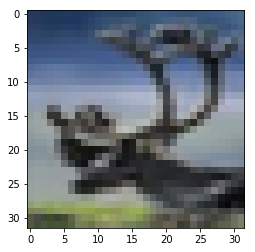

In [6]:
train_gen = generate_real_samples(X,X_cond,batch_size)
test_gen = generate_real_samples(T,T_cond,batch_size)

x,c = next(train_gen)
plt.imshow((x[0]+1)/2)
c[0]

In [7]:
# Discriminator

def build_discriminator():
#     print(condition_emb)
    inpImage = Input(shape=(32,32,3), name = 'DiscriminatorInput')
    



    d_model = Conv2D(filters=128, kernel_size=(2,2), strides=(1, 1), padding='same')(inpImage)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)
    d_model = MaxPooling2D((2,2))
    
    d_model, beta, gamma = Attention(128)(d_model)
    
    d_model = Conv2D(512, kernel_size=(2,2), strides=(1, 1), padding='same')(d_model)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)
    d_model = MaxPooling2D((2,2))
 
    
    
    d_model = Conv2D(1024, kernel_size=(4, 4), strides=(2, 2), padding='same')(d_model)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)


    d_model = Conv2D(1024, kernel_size=(4, 4), strides=(2, 2), padding='same')(d_model)
    d_model = BatchNormalization()(d_model)
    d_model = LeakyReLU(0.1)(d_model)

    d_model = GlobalAveragePooling2D()(d_model)
    d_model = Dense(10, activation='softmax',name='D')(d_model)
    
    d = Model(inpImage, d_model)
    d.compile(loss='categorical_crossentropy', optimizer=d_opt, metrics=['accuracy'])
    d.summary()
#     display(SVG(model_to_dot(discriminator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))
    return d
discriminator = build_discriminator()

(1, 1, 128, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DiscriminatorInput (InputLay (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       6272      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
attention_1 (Attention)      [(None, 16, 16, 128), (25 20641     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         1049088   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 512)         2048 

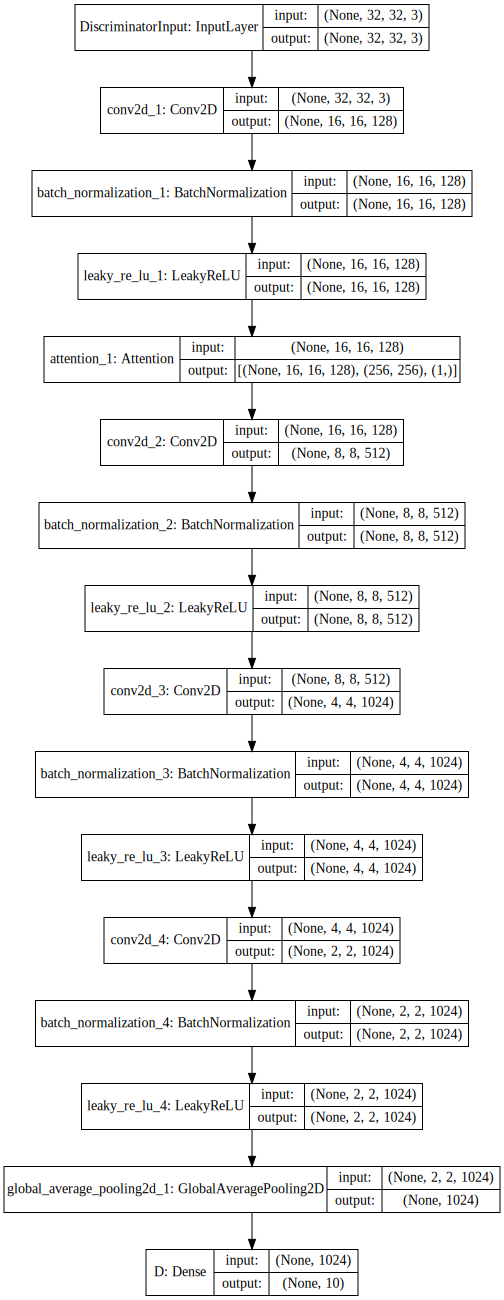

In [8]:

display(SVG(model_to_dot(model=discriminator,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg')))


In [9]:
hist = discriminator.fit_generator(train_gen
                            , validation_data=test_gen
                            , epochs=100000
                            , verbose=2
                            , steps_per_epoch=1
                            , validation_steps=1
                        , callbacks=[keras.callbacks.EarlyStopping(mode='max',monitor='acc',patience=1000,min_delta=0.01)])

Epoch 1/100000
 - 3s - loss: 2.6678 - acc: 0.0781 - val_loss: 10.3752 - val_acc: 0.1250
Epoch 2/100000
 - 0s - loss: 3.6854 - acc: 0.3750 - val_loss: 12.3108 - val_acc: 0.0781
Epoch 3/100000
 - 0s - loss: 4.5342 - acc: 0.2031 - val_loss: 7.1708 - val_acc: 0.2500
Epoch 4/100000
 - 0s - loss: 3.3386 - acc: 0.2969 - val_loss: 6.2081 - val_acc: 0.2500
Epoch 5/100000
 - 0s - loss: 2.9759 - acc: 0.2969 - val_loss: 4.8143 - val_acc: 0.1719
Epoch 6/100000
 - 0s - loss: 2.4172 - acc: 0.3281 - val_loss: 7.4864 - val_acc: 0.1562
Epoch 7/100000
 - 0s - loss: 3.5688 - acc: 0.1406 - val_loss: 6.7517 - val_acc: 0.2031
Epoch 8/100000
 - 0s - loss: 2.8561 - acc: 0.2344 - val_loss: 4.6491 - val_acc: 0.3125
Epoch 9/100000
 - 0s - loss: 2.5946 - acc: 0.2031 - val_loss: 3.5218 - val_acc: 0.2344
Epoch 10/100000
 - 0s - loss: 2.2969 - acc: 0.2812 - val_loss: 4.0785 - val_acc: 0.3125
Epoch 11/100000
 - 0s - loss: 2.3312 - acc: 0.2344 - val_loss: 3.0237 - val_acc: 0.2812
Epoch 12/100000
 - 0s - loss: 2.4495 - 

 - 0s - loss: 1.6085 - acc: 0.4062 - val_loss: 1.6943 - val_acc: 0.4375
Epoch 95/100000
 - 0s - loss: 1.4750 - acc: 0.5000 - val_loss: 1.4938 - val_acc: 0.5312
Epoch 96/100000
 - 0s - loss: 1.3342 - acc: 0.5000 - val_loss: 1.7758 - val_acc: 0.4375
Epoch 97/100000
 - 0s - loss: 1.5887 - acc: 0.3750 - val_loss: 1.8788 - val_acc: 0.3594
Epoch 98/100000
 - 0s - loss: 1.4862 - acc: 0.4375 - val_loss: 3.0675 - val_acc: 0.2969
Epoch 99/100000
 - 0s - loss: 1.6868 - acc: 0.3438 - val_loss: 1.7894 - val_acc: 0.4688
Epoch 100/100000
 - 0s - loss: 1.5262 - acc: 0.3594 - val_loss: 2.6693 - val_acc: 0.3281
Epoch 101/100000
 - 0s - loss: 1.5864 - acc: 0.3750 - val_loss: 1.6665 - val_acc: 0.4531
Epoch 102/100000
 - 0s - loss: 1.5697 - acc: 0.4375 - val_loss: 1.9746 - val_acc: 0.4062
Epoch 103/100000
 - 0s - loss: 1.2951 - acc: 0.5156 - val_loss: 1.5171 - val_acc: 0.4844
Epoch 104/100000
 - 0s - loss: 1.4810 - acc: 0.4844 - val_loss: 1.7522 - val_acc: 0.4219
Epoch 105/100000
 - 0s - loss: 1.4593 - acc

Epoch 187/100000
 - 0s - loss: 1.6260 - acc: 0.4531 - val_loss: 1.4741 - val_acc: 0.4844
Epoch 188/100000
 - 0s - loss: 1.3322 - acc: 0.5625 - val_loss: 1.6000 - val_acc: 0.4062
Epoch 189/100000
 - 0s - loss: 1.3115 - acc: 0.4844 - val_loss: 1.3368 - val_acc: 0.4688
Epoch 190/100000
 - 0s - loss: 1.3975 - acc: 0.4688 - val_loss: 2.0273 - val_acc: 0.3906
Epoch 191/100000
 - 0s - loss: 1.3366 - acc: 0.5000 - val_loss: 1.8889 - val_acc: 0.3594
Epoch 192/100000
 - 0s - loss: 1.1965 - acc: 0.5312 - val_loss: 1.4158 - val_acc: 0.5000
Epoch 193/100000
 - 0s - loss: 1.4807 - acc: 0.4844 - val_loss: 1.6964 - val_acc: 0.4062
Epoch 194/100000
 - 0s - loss: 1.5110 - acc: 0.4531 - val_loss: 1.8104 - val_acc: 0.4375
Epoch 195/100000
 - 0s - loss: 1.5868 - acc: 0.3906 - val_loss: 1.6416 - val_acc: 0.5000
Epoch 196/100000
 - 0s - loss: 1.5048 - acc: 0.4219 - val_loss: 1.7526 - val_acc: 0.3594
Epoch 197/100000
 - 0s - loss: 1.3585 - acc: 0.4688 - val_loss: 1.5056 - val_acc: 0.4531
Epoch 198/100000
 - 0

 - 0s - loss: 1.1480 - acc: 0.7188 - val_loss: 1.7243 - val_acc: 0.4375
Epoch 280/100000
 - 0s - loss: 1.4559 - acc: 0.4531 - val_loss: 1.9688 - val_acc: 0.4062
Epoch 281/100000
 - 0s - loss: 1.3062 - acc: 0.4688 - val_loss: 1.3826 - val_acc: 0.4688
Epoch 282/100000
 - 0s - loss: 1.2658 - acc: 0.5469 - val_loss: 1.0796 - val_acc: 0.5625
Epoch 283/100000
 - 0s - loss: 1.2628 - acc: 0.6406 - val_loss: 1.7104 - val_acc: 0.4062
Epoch 284/100000
 - 0s - loss: 1.1614 - acc: 0.6250 - val_loss: 1.3901 - val_acc: 0.3906
Epoch 285/100000
 - 0s - loss: 1.4369 - acc: 0.5469 - val_loss: 1.6350 - val_acc: 0.4375
Epoch 286/100000
 - 0s - loss: 1.3676 - acc: 0.5000 - val_loss: 1.5365 - val_acc: 0.5000
Epoch 287/100000
 - 0s - loss: 1.2147 - acc: 0.4844 - val_loss: 1.6022 - val_acc: 0.4219
Epoch 288/100000
 - 0s - loss: 1.2893 - acc: 0.5469 - val_loss: 2.1203 - val_acc: 0.3906
Epoch 289/100000
 - 0s - loss: 1.1572 - acc: 0.5156 - val_loss: 2.0540 - val_acc: 0.3750
Epoch 290/100000
 - 0s - loss: 1.0837 

Epoch 372/100000
 - 0s - loss: 1.4379 - acc: 0.5469 - val_loss: 1.8592 - val_acc: 0.4062
Epoch 373/100000
 - 0s - loss: 1.2050 - acc: 0.6094 - val_loss: 1.5334 - val_acc: 0.5000
Epoch 374/100000
 - 0s - loss: 1.3055 - acc: 0.4844 - val_loss: 1.8513 - val_acc: 0.3906
Epoch 375/100000
 - 0s - loss: 1.2857 - acc: 0.5156 - val_loss: 1.1982 - val_acc: 0.5469
Epoch 376/100000
 - 0s - loss: 1.2290 - acc: 0.5312 - val_loss: 1.2416 - val_acc: 0.5312
Epoch 377/100000
 - 0s - loss: 1.0639 - acc: 0.6250 - val_loss: 1.5057 - val_acc: 0.5156
Epoch 378/100000
 - 0s - loss: 1.3768 - acc: 0.4844 - val_loss: 1.7175 - val_acc: 0.4688
Epoch 379/100000
 - 0s - loss: 1.5270 - acc: 0.5000 - val_loss: 1.7780 - val_acc: 0.4531
Epoch 380/100000
 - 0s - loss: 1.2937 - acc: 0.5781 - val_loss: 1.5916 - val_acc: 0.5156
Epoch 381/100000
 - 0s - loss: 1.2667 - acc: 0.4688 - val_loss: 1.3877 - val_acc: 0.4844
Epoch 382/100000
 - 0s - loss: 1.2615 - acc: 0.5781 - val_loss: 1.3665 - val_acc: 0.6094
Epoch 383/100000
 - 0

 - 0s - loss: 1.1274 - acc: 0.5781 - val_loss: 1.3568 - val_acc: 0.5312
Epoch 465/100000
 - 0s - loss: 1.1444 - acc: 0.6250 - val_loss: 1.3995 - val_acc: 0.5469
Epoch 466/100000
 - 0s - loss: 1.0720 - acc: 0.6406 - val_loss: 1.2423 - val_acc: 0.5625
Epoch 467/100000
 - 0s - loss: 0.9025 - acc: 0.7031 - val_loss: 1.2227 - val_acc: 0.4844
Epoch 468/100000
 - 0s - loss: 0.8024 - acc: 0.7031 - val_loss: 1.1664 - val_acc: 0.5625
Epoch 469/100000
 - 0s - loss: 1.0096 - acc: 0.7031 - val_loss: 1.3472 - val_acc: 0.5469
Epoch 470/100000
 - 0s - loss: 0.9576 - acc: 0.6719 - val_loss: 1.2194 - val_acc: 0.5938
Epoch 471/100000
 - 0s - loss: 1.1856 - acc: 0.5312 - val_loss: 1.1799 - val_acc: 0.6562
Epoch 472/100000
 - 0s - loss: 1.1971 - acc: 0.5781 - val_loss: 1.1200 - val_acc: 0.5781
Epoch 473/100000
 - 0s - loss: 0.9765 - acc: 0.6094 - val_loss: 1.4473 - val_acc: 0.5156
Epoch 474/100000
 - 0s - loss: 0.8670 - acc: 0.6406 - val_loss: 1.1903 - val_acc: 0.6562
Epoch 475/100000
 - 0s - loss: 0.9800 

Epoch 557/100000
 - 0s - loss: 1.1257 - acc: 0.5625 - val_loss: 1.7026 - val_acc: 0.4062
Epoch 558/100000
 - 0s - loss: 1.1365 - acc: 0.5938 - val_loss: 1.5431 - val_acc: 0.4531
Epoch 559/100000
 - 0s - loss: 1.2738 - acc: 0.5469 - val_loss: 1.3789 - val_acc: 0.5469
Epoch 560/100000
 - 0s - loss: 1.0459 - acc: 0.6094 - val_loss: 1.1999 - val_acc: 0.5938
Epoch 561/100000
 - 0s - loss: 1.0979 - acc: 0.6406 - val_loss: 1.1976 - val_acc: 0.5938
Epoch 562/100000
 - 0s - loss: 1.3550 - acc: 0.5625 - val_loss: 1.4941 - val_acc: 0.5156
Epoch 563/100000
 - 0s - loss: 1.3914 - acc: 0.5938 - val_loss: 1.5263 - val_acc: 0.4844
Epoch 564/100000
 - 0s - loss: 1.0283 - acc: 0.6094 - val_loss: 1.2069 - val_acc: 0.5781
Epoch 565/100000
 - 0s - loss: 1.3839 - acc: 0.5625 - val_loss: 1.3300 - val_acc: 0.5469
Epoch 566/100000
 - 0s - loss: 1.0964 - acc: 0.6562 - val_loss: 1.0936 - val_acc: 0.5625
Epoch 567/100000
 - 0s - loss: 1.1128 - acc: 0.5312 - val_loss: 1.2926 - val_acc: 0.5625
Epoch 568/100000
 - 0

 - 0s - loss: 0.8324 - acc: 0.6875 - val_loss: 1.2167 - val_acc: 0.6719
Epoch 650/100000
 - 0s - loss: 0.7504 - acc: 0.7812 - val_loss: 1.2514 - val_acc: 0.5781
Epoch 651/100000
 - 0s - loss: 1.1062 - acc: 0.5469 - val_loss: 1.5874 - val_acc: 0.5000
Epoch 652/100000
 - 0s - loss: 1.1521 - acc: 0.5469 - val_loss: 1.1622 - val_acc: 0.5312
Epoch 653/100000
 - 0s - loss: 1.1146 - acc: 0.5938 - val_loss: 1.3474 - val_acc: 0.4844
Epoch 654/100000
 - 0s - loss: 0.9389 - acc: 0.6406 - val_loss: 1.2846 - val_acc: 0.5469
Epoch 655/100000
 - 0s - loss: 0.7902 - acc: 0.7031 - val_loss: 1.3502 - val_acc: 0.5156
Epoch 656/100000
 - 0s - loss: 1.3398 - acc: 0.5625 - val_loss: 1.1788 - val_acc: 0.6094
Epoch 657/100000
 - 0s - loss: 0.9503 - acc: 0.6562 - val_loss: 1.6646 - val_acc: 0.4219
Epoch 658/100000
 - 0s - loss: 0.8122 - acc: 0.7031 - val_loss: 1.2095 - val_acc: 0.5469
Epoch 659/100000
 - 0s - loss: 0.9531 - acc: 0.7188 - val_loss: 1.3402 - val_acc: 0.6562
Epoch 660/100000
 - 0s - loss: 0.9955 

Epoch 742/100000
 - 0s - loss: 1.1035 - acc: 0.6250 - val_loss: 0.9892 - val_acc: 0.6406
Epoch 743/100000
 - 0s - loss: 1.0704 - acc: 0.6094 - val_loss: 1.1377 - val_acc: 0.5781
Epoch 744/100000
 - 0s - loss: 0.8754 - acc: 0.6406 - val_loss: 1.5581 - val_acc: 0.5156
Epoch 745/100000
 - 0s - loss: 1.1866 - acc: 0.5625 - val_loss: 1.0476 - val_acc: 0.6094
Epoch 746/100000
 - 0s - loss: 0.7906 - acc: 0.6875 - val_loss: 0.7519 - val_acc: 0.6875
Epoch 747/100000
 - 0s - loss: 1.0373 - acc: 0.6094 - val_loss: 1.1735 - val_acc: 0.6250
Epoch 748/100000
 - 0s - loss: 0.9777 - acc: 0.6406 - val_loss: 1.1765 - val_acc: 0.5156
Epoch 749/100000
 - 0s - loss: 1.1095 - acc: 0.5469 - val_loss: 1.1367 - val_acc: 0.6719
Epoch 750/100000
 - 0s - loss: 1.1015 - acc: 0.6719 - val_loss: 0.9003 - val_acc: 0.7656
Epoch 751/100000
 - 0s - loss: 0.8386 - acc: 0.6719 - val_loss: 1.2292 - val_acc: 0.5938
Epoch 752/100000
 - 0s - loss: 0.9694 - acc: 0.6094 - val_loss: 1.1064 - val_acc: 0.5625
Epoch 753/100000
 - 0

 - 0s - loss: 0.9494 - acc: 0.6562 - val_loss: 1.0761 - val_acc: 0.6094
Epoch 835/100000
 - 0s - loss: 0.8664 - acc: 0.6250 - val_loss: 1.0436 - val_acc: 0.5625
Epoch 836/100000
 - 0s - loss: 0.7125 - acc: 0.7812 - val_loss: 1.0551 - val_acc: 0.6719
Epoch 837/100000
 - 0s - loss: 0.9481 - acc: 0.7188 - val_loss: 1.1052 - val_acc: 0.6250
Epoch 838/100000
 - 0s - loss: 0.9244 - acc: 0.7656 - val_loss: 1.1014 - val_acc: 0.6094
Epoch 839/100000
 - 0s - loss: 0.8750 - acc: 0.7344 - val_loss: 1.3365 - val_acc: 0.5781
Epoch 840/100000
 - 0s - loss: 0.8034 - acc: 0.7344 - val_loss: 1.1071 - val_acc: 0.6250
Epoch 841/100000
 - 0s - loss: 1.2448 - acc: 0.5469 - val_loss: 1.0460 - val_acc: 0.6562
Epoch 842/100000
 - 0s - loss: 0.8297 - acc: 0.6875 - val_loss: 1.0947 - val_acc: 0.5781
Epoch 843/100000
 - 0s - loss: 1.0555 - acc: 0.5938 - val_loss: 0.9948 - val_acc: 0.6406
Epoch 844/100000
 - 0s - loss: 0.9935 - acc: 0.6719 - val_loss: 0.9869 - val_acc: 0.6719
Epoch 845/100000
 - 0s - loss: 0.7406 

Epoch 927/100000
 - 0s - loss: 1.0241 - acc: 0.6406 - val_loss: 1.1834 - val_acc: 0.6250
Epoch 928/100000
 - 0s - loss: 1.1141 - acc: 0.6875 - val_loss: 1.2770 - val_acc: 0.5469
Epoch 929/100000
 - 0s - loss: 1.0666 - acc: 0.5625 - val_loss: 1.5105 - val_acc: 0.5156
Epoch 930/100000
 - 0s - loss: 0.9253 - acc: 0.6719 - val_loss: 1.1282 - val_acc: 0.6094
Epoch 931/100000
 - 0s - loss: 0.8544 - acc: 0.6406 - val_loss: 0.9893 - val_acc: 0.6562
Epoch 932/100000
 - 0s - loss: 0.7108 - acc: 0.7812 - val_loss: 1.0803 - val_acc: 0.6094
Epoch 933/100000
 - 0s - loss: 0.8978 - acc: 0.6562 - val_loss: 1.2017 - val_acc: 0.5938
Epoch 934/100000
 - 0s - loss: 1.0730 - acc: 0.5938 - val_loss: 0.9365 - val_acc: 0.6562
Epoch 935/100000
 - 0s - loss: 0.8061 - acc: 0.6875 - val_loss: 1.1482 - val_acc: 0.5938
Epoch 936/100000
 - 0s - loss: 1.0497 - acc: 0.6094 - val_loss: 1.0533 - val_acc: 0.6562
Epoch 937/100000
 - 0s - loss: 1.0482 - acc: 0.6719 - val_loss: 1.1828 - val_acc: 0.5625
Epoch 938/100000
 - 0

Epoch 1019/100000
 - 0s - loss: 0.9686 - acc: 0.7188 - val_loss: 1.0720 - val_acc: 0.6406
Epoch 1020/100000
 - 0s - loss: 0.8048 - acc: 0.7188 - val_loss: 1.2094 - val_acc: 0.6094
Epoch 1021/100000
 - 0s - loss: 0.8127 - acc: 0.7188 - val_loss: 1.0335 - val_acc: 0.5938
Epoch 1022/100000
 - 0s - loss: 0.7803 - acc: 0.6875 - val_loss: 1.0272 - val_acc: 0.6719
Epoch 1023/100000
 - 0s - loss: 0.7604 - acc: 0.7031 - val_loss: 1.4479 - val_acc: 0.5312
Epoch 1024/100000
 - 0s - loss: 0.9558 - acc: 0.6562 - val_loss: 1.1877 - val_acc: 0.6719
Epoch 1025/100000
 - 0s - loss: 1.0127 - acc: 0.7031 - val_loss: 1.5981 - val_acc: 0.5000
Epoch 1026/100000
 - 0s - loss: 0.8804 - acc: 0.6719 - val_loss: 1.0424 - val_acc: 0.5781
Epoch 1027/100000
 - 0s - loss: 0.8568 - acc: 0.6406 - val_loss: 1.1337 - val_acc: 0.5938
Epoch 1028/100000
 - 0s - loss: 0.6222 - acc: 0.7500 - val_loss: 0.7868 - val_acc: 0.7031
Epoch 1029/100000
 - 0s - loss: 0.6698 - acc: 0.7812 - val_loss: 1.1407 - val_acc: 0.5625
Epoch 1030

 - 0s - loss: 0.9460 - acc: 0.6562 - val_loss: 1.1386 - val_acc: 0.6562
Epoch 1111/100000
 - 0s - loss: 0.9181 - acc: 0.6562 - val_loss: 0.9535 - val_acc: 0.7031
Epoch 1112/100000
 - 0s - loss: 0.7719 - acc: 0.6875 - val_loss: 1.0319 - val_acc: 0.5781
Epoch 1113/100000
 - 0s - loss: 0.9904 - acc: 0.6875 - val_loss: 1.0226 - val_acc: 0.6562
Epoch 1114/100000
 - 0s - loss: 0.7293 - acc: 0.7500 - val_loss: 1.1690 - val_acc: 0.5938
Epoch 1115/100000
 - 0s - loss: 0.9803 - acc: 0.6562 - val_loss: 0.8419 - val_acc: 0.7188
Epoch 1116/100000
 - 0s - loss: 1.0204 - acc: 0.6250 - val_loss: 0.9980 - val_acc: 0.6719
Epoch 1117/100000
 - 0s - loss: 0.7307 - acc: 0.7656 - val_loss: 0.9679 - val_acc: 0.6719
Epoch 1118/100000
 - 0s - loss: 0.8615 - acc: 0.6719 - val_loss: 0.9840 - val_acc: 0.6719
Epoch 1119/100000
 - 0s - loss: 0.5199 - acc: 0.8438 - val_loss: 1.4447 - val_acc: 0.5938
Epoch 1120/100000
 - 0s - loss: 0.7263 - acc: 0.7344 - val_loss: 1.1090 - val_acc: 0.6875
Epoch 1121/100000
 - 0s - lo

Epoch 1202/100000
 - 0s - loss: 0.8331 - acc: 0.6562 - val_loss: 1.3020 - val_acc: 0.5781
Epoch 1203/100000
 - 0s - loss: 0.9842 - acc: 0.6406 - val_loss: 1.1468 - val_acc: 0.5469
Epoch 1204/100000
 - 0s - loss: 0.9734 - acc: 0.6875 - val_loss: 1.0048 - val_acc: 0.6875
Epoch 1205/100000
 - 0s - loss: 0.9223 - acc: 0.6562 - val_loss: 1.1632 - val_acc: 0.6094
Epoch 1206/100000
 - 0s - loss: 0.6932 - acc: 0.7500 - val_loss: 0.9245 - val_acc: 0.7188
Epoch 1207/100000
 - 0s - loss: 0.7884 - acc: 0.7188 - val_loss: 0.9368 - val_acc: 0.6719
Epoch 1208/100000
 - 0s - loss: 0.7379 - acc: 0.7500 - val_loss: 0.9058 - val_acc: 0.6875
Epoch 1209/100000
 - 0s - loss: 0.7926 - acc: 0.7188 - val_loss: 0.9217 - val_acc: 0.7344
Epoch 1210/100000
 - 0s - loss: 0.8743 - acc: 0.7031 - val_loss: 0.8271 - val_acc: 0.6719
Epoch 1211/100000
 - 0s - loss: 0.7971 - acc: 0.7188 - val_loss: 0.9641 - val_acc: 0.5781
Epoch 1212/100000
 - 0s - loss: 0.6726 - acc: 0.7656 - val_loss: 0.9918 - val_acc: 0.6719
Epoch 1213

 - 0s - loss: 0.7600 - acc: 0.7188 - val_loss: 0.8487 - val_acc: 0.6719
Epoch 1294/100000
 - 0s - loss: 0.8770 - acc: 0.7344 - val_loss: 1.7691 - val_acc: 0.5156
Epoch 1295/100000
 - 0s - loss: 0.6434 - acc: 0.7656 - val_loss: 0.9371 - val_acc: 0.6406
Epoch 1296/100000
 - 0s - loss: 0.7858 - acc: 0.6719 - val_loss: 0.9733 - val_acc: 0.6875
Epoch 1297/100000
 - 0s - loss: 0.7772 - acc: 0.7031 - val_loss: 1.2906 - val_acc: 0.6406
Epoch 1298/100000
 - 0s - loss: 0.7695 - acc: 0.7188 - val_loss: 1.0154 - val_acc: 0.6250
Epoch 1299/100000
 - 0s - loss: 0.6700 - acc: 0.7812 - val_loss: 1.3324 - val_acc: 0.5781
Epoch 1300/100000
 - 0s - loss: 0.7002 - acc: 0.7188 - val_loss: 1.2658 - val_acc: 0.6094
Epoch 1301/100000
 - 0s - loss: 0.8931 - acc: 0.7500 - val_loss: 1.3384 - val_acc: 0.5000
Epoch 1302/100000
 - 0s - loss: 0.7777 - acc: 0.7344 - val_loss: 1.1581 - val_acc: 0.5625
Epoch 1303/100000
 - 0s - loss: 0.3395 - acc: 0.9062 - val_loss: 0.8232 - val_acc: 0.7344
Epoch 1304/100000
 - 0s - lo

Epoch 1385/100000
 - 0s - loss: 0.7393 - acc: 0.6719 - val_loss: 1.2247 - val_acc: 0.6562
Epoch 1386/100000
 - 0s - loss: 0.8684 - acc: 0.7188 - val_loss: 1.1872 - val_acc: 0.5938
Epoch 1387/100000
 - 0s - loss: 0.9069 - acc: 0.7344 - val_loss: 1.1280 - val_acc: 0.6406
Epoch 1388/100000
 - 0s - loss: 0.7532 - acc: 0.7188 - val_loss: 0.8798 - val_acc: 0.6875
Epoch 1389/100000
 - 0s - loss: 0.7345 - acc: 0.7500 - val_loss: 0.9706 - val_acc: 0.6719
Epoch 1390/100000
 - 0s - loss: 0.9238 - acc: 0.6562 - val_loss: 1.4901 - val_acc: 0.5625
Epoch 1391/100000
 - 0s - loss: 0.8398 - acc: 0.6875 - val_loss: 1.1756 - val_acc: 0.5781
Epoch 1392/100000
 - 0s - loss: 0.7757 - acc: 0.7656 - val_loss: 0.9929 - val_acc: 0.6875
Epoch 1393/100000
 - 0s - loss: 0.4584 - acc: 0.8750 - val_loss: 1.1572 - val_acc: 0.5781
Epoch 1394/100000
 - 0s - loss: 0.7907 - acc: 0.7031 - val_loss: 1.4651 - val_acc: 0.5312
Epoch 1395/100000
 - 0s - loss: 1.0951 - acc: 0.6562 - val_loss: 1.1199 - val_acc: 0.6406
Epoch 1396

 - 0s - loss: 0.7224 - acc: 0.7969 - val_loss: 0.8217 - val_acc: 0.5781
Epoch 1477/100000
 - 0s - loss: 0.6950 - acc: 0.7344 - val_loss: 0.9446 - val_acc: 0.7344
Epoch 1478/100000
 - 0s - loss: 0.7628 - acc: 0.7344 - val_loss: 1.1058 - val_acc: 0.6250
Epoch 1479/100000
 - 0s - loss: 1.0066 - acc: 0.7188 - val_loss: 1.0808 - val_acc: 0.7031
Epoch 1480/100000
 - 0s - loss: 0.6340 - acc: 0.7812 - val_loss: 1.1949 - val_acc: 0.6094
Epoch 1481/100000
 - 0s - loss: 0.6246 - acc: 0.8125 - val_loss: 0.9883 - val_acc: 0.6094
Epoch 1482/100000
 - 0s - loss: 0.6437 - acc: 0.7812 - val_loss: 1.0451 - val_acc: 0.6406
Epoch 1483/100000
 - 0s - loss: 0.8083 - acc: 0.7812 - val_loss: 1.4260 - val_acc: 0.5781
Epoch 1484/100000
 - 0s - loss: 0.6634 - acc: 0.8438 - val_loss: 0.9791 - val_acc: 0.7031
Epoch 1485/100000
 - 0s - loss: 0.6203 - acc: 0.7500 - val_loss: 0.7664 - val_acc: 0.7188
Epoch 1486/100000
 - 0s - loss: 0.7655 - acc: 0.6719 - val_loss: 1.2979 - val_acc: 0.5625
Epoch 1487/100000
 - 0s - lo

Epoch 1568/100000
 - 0s - loss: 0.7968 - acc: 0.7656 - val_loss: 0.9199 - val_acc: 0.6875
Epoch 1569/100000
 - 0s - loss: 0.6186 - acc: 0.8281 - val_loss: 0.8655 - val_acc: 0.6875
Epoch 1570/100000
 - 0s - loss: 0.6189 - acc: 0.8438 - val_loss: 0.9349 - val_acc: 0.6719
Epoch 1571/100000
 - 0s - loss: 0.5560 - acc: 0.7969 - val_loss: 0.8994 - val_acc: 0.7031
Epoch 1572/100000
 - 0s - loss: 0.8843 - acc: 0.6562 - val_loss: 1.0455 - val_acc: 0.6250
Epoch 1573/100000
 - 0s - loss: 0.9506 - acc: 0.6719 - val_loss: 1.0626 - val_acc: 0.7188
Epoch 1574/100000
 - 0s - loss: 0.6846 - acc: 0.7656 - val_loss: 1.0504 - val_acc: 0.6094
Epoch 1575/100000
 - 0s - loss: 0.6409 - acc: 0.7969 - val_loss: 1.0882 - val_acc: 0.6094
Epoch 1576/100000
 - 0s - loss: 0.5742 - acc: 0.7344 - val_loss: 1.1947 - val_acc: 0.5781
Epoch 1577/100000
 - 0s - loss: 0.6844 - acc: 0.7500 - val_loss: 1.2713 - val_acc: 0.5938
Epoch 1578/100000
 - 0s - loss: 0.7291 - acc: 0.7344 - val_loss: 0.8477 - val_acc: 0.6875
Epoch 1579

 - 0s - loss: 0.6353 - acc: 0.7969 - val_loss: 0.7184 - val_acc: 0.7031
Epoch 1660/100000
 - 0s - loss: 0.6326 - acc: 0.7812 - val_loss: 1.1876 - val_acc: 0.5312
Epoch 1661/100000
 - 0s - loss: 0.5955 - acc: 0.8438 - val_loss: 1.2967 - val_acc: 0.5938
Epoch 1662/100000
 - 0s - loss: 0.6703 - acc: 0.7500 - val_loss: 0.9700 - val_acc: 0.6719
Epoch 1663/100000
 - 0s - loss: 0.9354 - acc: 0.7188 - val_loss: 1.0912 - val_acc: 0.6875
Epoch 1664/100000
 - 0s - loss: 0.6289 - acc: 0.7969 - val_loss: 1.1940 - val_acc: 0.6719
Epoch 1665/100000
 - 0s - loss: 0.6427 - acc: 0.7969 - val_loss: 0.8786 - val_acc: 0.6406
Epoch 1666/100000
 - 0s - loss: 0.6124 - acc: 0.7969 - val_loss: 1.0354 - val_acc: 0.6719
Epoch 1667/100000
 - 0s - loss: 0.5232 - acc: 0.8438 - val_loss: 0.9868 - val_acc: 0.7031
Epoch 1668/100000
 - 0s - loss: 0.4811 - acc: 0.8594 - val_loss: 0.9260 - val_acc: 0.6875
Epoch 1669/100000
 - 0s - loss: 0.6389 - acc: 0.7344 - val_loss: 1.2142 - val_acc: 0.6875
Epoch 1670/100000
 - 0s - lo

Epoch 1751/100000
 - 0s - loss: 0.7347 - acc: 0.7500 - val_loss: 0.9472 - val_acc: 0.6875
Epoch 1752/100000
 - 0s - loss: 0.5067 - acc: 0.8281 - val_loss: 0.9340 - val_acc: 0.6719
Epoch 1753/100000
 - 0s - loss: 0.7073 - acc: 0.7500 - val_loss: 1.4388 - val_acc: 0.5000
Epoch 1754/100000
 - 0s - loss: 0.7220 - acc: 0.7969 - val_loss: 1.1835 - val_acc: 0.6719
Epoch 1755/100000
 - 0s - loss: 0.5092 - acc: 0.8281 - val_loss: 0.6803 - val_acc: 0.7031
Epoch 1756/100000
 - 0s - loss: 0.6122 - acc: 0.7031 - val_loss: 0.7743 - val_acc: 0.7656
Epoch 1757/100000
 - 0s - loss: 0.7139 - acc: 0.7500 - val_loss: 0.8185 - val_acc: 0.7500
Epoch 1758/100000
 - 0s - loss: 0.8300 - acc: 0.6875 - val_loss: 0.8336 - val_acc: 0.6094
Epoch 1759/100000
 - 0s - loss: 0.8313 - acc: 0.7344 - val_loss: 1.1008 - val_acc: 0.6406
Epoch 1760/100000
 - 0s - loss: 0.6139 - acc: 0.7969 - val_loss: 1.0933 - val_acc: 0.6875
Epoch 1761/100000
 - 0s - loss: 0.6923 - acc: 0.7188 - val_loss: 1.1678 - val_acc: 0.6094
Epoch 1762

 - 0s - loss: 0.5678 - acc: 0.7812 - val_loss: 0.8183 - val_acc: 0.7031
Epoch 1843/100000
 - 0s - loss: 0.3477 - acc: 0.8594 - val_loss: 0.8324 - val_acc: 0.7188
Epoch 1844/100000
 - 0s - loss: 0.8216 - acc: 0.7812 - val_loss: 1.0666 - val_acc: 0.6406
Epoch 1845/100000
 - 0s - loss: 0.4749 - acc: 0.7812 - val_loss: 1.0869 - val_acc: 0.5938
Epoch 1846/100000
 - 0s - loss: 0.6540 - acc: 0.7812 - val_loss: 1.0764 - val_acc: 0.6406
Epoch 1847/100000
 - 0s - loss: 0.7677 - acc: 0.7656 - val_loss: 0.9267 - val_acc: 0.7344
Epoch 1848/100000
 - 0s - loss: 0.7226 - acc: 0.7188 - val_loss: 1.0872 - val_acc: 0.6719
Epoch 1849/100000
 - 0s - loss: 0.5210 - acc: 0.7969 - val_loss: 1.1161 - val_acc: 0.6094
Epoch 1850/100000
 - 0s - loss: 0.6808 - acc: 0.7812 - val_loss: 0.9936 - val_acc: 0.7188
Epoch 1851/100000
 - 0s - loss: 0.7934 - acc: 0.7812 - val_loss: 0.9896 - val_acc: 0.6406
Epoch 1852/100000
 - 0s - loss: 0.5353 - acc: 0.7969 - val_loss: 0.8455 - val_acc: 0.6562
Epoch 1853/100000
 - 0s - lo

Epoch 1934/100000
 - 0s - loss: 0.7436 - acc: 0.7031 - val_loss: 0.7741 - val_acc: 0.7656
Epoch 1935/100000
 - 0s - loss: 0.9799 - acc: 0.6875 - val_loss: 0.8943 - val_acc: 0.7500
Epoch 1936/100000
 - 0s - loss: 0.6449 - acc: 0.7969 - val_loss: 1.3588 - val_acc: 0.6562
Epoch 1937/100000
 - 0s - loss: 0.7030 - acc: 0.7969 - val_loss: 0.9272 - val_acc: 0.6875
Epoch 1938/100000
 - 0s - loss: 0.5774 - acc: 0.8125 - val_loss: 0.9190 - val_acc: 0.6875
Epoch 1939/100000
 - 0s - loss: 0.4817 - acc: 0.8125 - val_loss: 1.1748 - val_acc: 0.6094
Epoch 1940/100000
 - 0s - loss: 0.5030 - acc: 0.8438 - val_loss: 0.9021 - val_acc: 0.6875
Epoch 1941/100000
 - 0s - loss: 0.6765 - acc: 0.7812 - val_loss: 0.6660 - val_acc: 0.7500
Epoch 1942/100000
 - 0s - loss: 0.5667 - acc: 0.7969 - val_loss: 1.0012 - val_acc: 0.6094
Epoch 1943/100000
 - 0s - loss: 0.6268 - acc: 0.7656 - val_loss: 0.9908 - val_acc: 0.6094
Epoch 1944/100000
 - 0s - loss: 0.4478 - acc: 0.8750 - val_loss: 0.8979 - val_acc: 0.7188
Epoch 1945

 - 0s - loss: 0.4520 - acc: 0.7969 - val_loss: 0.6735 - val_acc: 0.7656
Epoch 2026/100000
 - 0s - loss: 0.7550 - acc: 0.7500 - val_loss: 0.7919 - val_acc: 0.7188
Epoch 2027/100000
 - 0s - loss: 0.6879 - acc: 0.7344 - val_loss: 1.0028 - val_acc: 0.7344
Epoch 2028/100000
 - 0s - loss: 0.4973 - acc: 0.8125 - val_loss: 0.8155 - val_acc: 0.6875
Epoch 2029/100000
 - 0s - loss: 0.6829 - acc: 0.7344 - val_loss: 0.8021 - val_acc: 0.7188
Epoch 2030/100000
 - 0s - loss: 0.6087 - acc: 0.7500 - val_loss: 1.2026 - val_acc: 0.5781
Epoch 2031/100000
 - 0s - loss: 0.7276 - acc: 0.7812 - val_loss: 1.0543 - val_acc: 0.5781
Epoch 2032/100000
 - 0s - loss: 0.4363 - acc: 0.8281 - val_loss: 0.9320 - val_acc: 0.6875
Epoch 2033/100000
 - 0s - loss: 0.7305 - acc: 0.7812 - val_loss: 1.3527 - val_acc: 0.6094
Epoch 2034/100000
 - 0s - loss: 0.5924 - acc: 0.7969 - val_loss: 1.1517 - val_acc: 0.6406
Epoch 2035/100000
 - 0s - loss: 0.4032 - acc: 0.8594 - val_loss: 0.5640 - val_acc: 0.7969
Epoch 2036/100000
 - 0s - lo

Epoch 2117/100000
 - 0s - loss: 0.5978 - acc: 0.8125 - val_loss: 1.1558 - val_acc: 0.6562
Epoch 2118/100000
 - 0s - loss: 0.5575 - acc: 0.7969 - val_loss: 0.7183 - val_acc: 0.8125
Epoch 2119/100000
 - 0s - loss: 0.4599 - acc: 0.8438 - val_loss: 1.1750 - val_acc: 0.6562
Epoch 2120/100000
 - 0s - loss: 0.5935 - acc: 0.8438 - val_loss: 0.5433 - val_acc: 0.7969
Epoch 2121/100000
 - 0s - loss: 0.5537 - acc: 0.8125 - val_loss: 0.6995 - val_acc: 0.7188
Epoch 2122/100000
 - 0s - loss: 0.6502 - acc: 0.7656 - val_loss: 0.7556 - val_acc: 0.7031
Epoch 2123/100000
 - 0s - loss: 0.4622 - acc: 0.8438 - val_loss: 1.3968 - val_acc: 0.6094
Epoch 2124/100000
 - 0s - loss: 0.5708 - acc: 0.8594 - val_loss: 0.8775 - val_acc: 0.7500
Epoch 2125/100000
 - 0s - loss: 0.6848 - acc: 0.7656 - val_loss: 0.7025 - val_acc: 0.7344
Epoch 2126/100000
 - 0s - loss: 0.4781 - acc: 0.8750 - val_loss: 1.0908 - val_acc: 0.6406
Epoch 2127/100000
 - 0s - loss: 0.7070 - acc: 0.7500 - val_loss: 0.9711 - val_acc: 0.7188
Epoch 2128

 - 0s - loss: 0.5114 - acc: 0.8438 - val_loss: 1.1332 - val_acc: 0.6562
Epoch 2209/100000
 - 0s - loss: 0.4431 - acc: 0.8594 - val_loss: 1.1257 - val_acc: 0.6250
Epoch 2210/100000
 - 0s - loss: 0.5706 - acc: 0.7969 - val_loss: 1.1784 - val_acc: 0.5938
Epoch 2211/100000
 - 0s - loss: 0.5810 - acc: 0.7344 - val_loss: 1.1962 - val_acc: 0.6406
Epoch 2212/100000
 - 0s - loss: 0.5913 - acc: 0.7969 - val_loss: 0.8669 - val_acc: 0.6562
Epoch 2213/100000
 - 0s - loss: 0.5462 - acc: 0.7812 - val_loss: 1.1841 - val_acc: 0.6094
Epoch 2214/100000
 - 0s - loss: 0.6413 - acc: 0.7812 - val_loss: 1.2190 - val_acc: 0.6406
Epoch 2215/100000
 - 0s - loss: 0.4561 - acc: 0.8125 - val_loss: 0.8461 - val_acc: 0.7344
Epoch 2216/100000
 - 0s - loss: 0.4595 - acc: 0.8594 - val_loss: 0.9485 - val_acc: 0.7031
Epoch 2217/100000
 - 0s - loss: 0.3877 - acc: 0.8594 - val_loss: 1.4396 - val_acc: 0.5625
Epoch 2218/100000
 - 0s - loss: 0.6841 - acc: 0.7812 - val_loss: 0.7571 - val_acc: 0.6875
Epoch 2219/100000
 - 0s - lo

Epoch 2300/100000
 - 0s - loss: 0.5967 - acc: 0.7500 - val_loss: 1.0807 - val_acc: 0.6875
Epoch 2301/100000
 - 0s - loss: 0.5098 - acc: 0.8281 - val_loss: 0.9261 - val_acc: 0.7500
Epoch 2302/100000
 - 0s - loss: 0.4574 - acc: 0.8125 - val_loss: 0.9681 - val_acc: 0.6719
Epoch 2303/100000
 - 0s - loss: 0.4953 - acc: 0.7969 - val_loss: 0.8506 - val_acc: 0.6875
Epoch 2304/100000
 - 0s - loss: 0.7389 - acc: 0.8125 - val_loss: 0.8975 - val_acc: 0.6250
Epoch 2305/100000
 - 0s - loss: 0.7093 - acc: 0.7812 - val_loss: 1.0321 - val_acc: 0.7188
Epoch 2306/100000
 - 0s - loss: 0.5430 - acc: 0.7812 - val_loss: 1.0062 - val_acc: 0.6875
Epoch 2307/100000
 - 0s - loss: 0.5207 - acc: 0.8594 - val_loss: 1.0144 - val_acc: 0.6250
Epoch 2308/100000
 - 0s - loss: 0.4861 - acc: 0.8281 - val_loss: 0.8154 - val_acc: 0.7344
Epoch 2309/100000
 - 0s - loss: 0.4333 - acc: 0.8750 - val_loss: 0.9007 - val_acc: 0.6875
Epoch 2310/100000
 - 0s - loss: 0.4874 - acc: 0.8125 - val_loss: 1.2421 - val_acc: 0.6406
Epoch 2311

 - 0s - loss: 0.3807 - acc: 0.8594 - val_loss: 1.0816 - val_acc: 0.7031
Epoch 2392/100000
 - 0s - loss: 0.3566 - acc: 0.9062 - val_loss: 0.8022 - val_acc: 0.7500
Epoch 2393/100000
 - 0s - loss: 0.3877 - acc: 0.9062 - val_loss: 1.1023 - val_acc: 0.6719
Epoch 2394/100000
 - 0s - loss: 0.4936 - acc: 0.8594 - val_loss: 0.7372 - val_acc: 0.7188
Epoch 2395/100000
 - 0s - loss: 0.4379 - acc: 0.7969 - val_loss: 1.0290 - val_acc: 0.6406
Epoch 2396/100000
 - 0s - loss: 0.3218 - acc: 0.8750 - val_loss: 0.7524 - val_acc: 0.7969
Epoch 2397/100000
 - 0s - loss: 0.4782 - acc: 0.8281 - val_loss: 0.9861 - val_acc: 0.6875
Epoch 2398/100000
 - 0s - loss: 0.4430 - acc: 0.8594 - val_loss: 1.0858 - val_acc: 0.6562
Epoch 2399/100000
 - 0s - loss: 0.3478 - acc: 0.8594 - val_loss: 0.8387 - val_acc: 0.6875
Epoch 2400/100000
 - 0s - loss: 0.3031 - acc: 0.8906 - val_loss: 1.1425 - val_acc: 0.6719
Epoch 2401/100000
 - 0s - loss: 0.2826 - acc: 0.9062 - val_loss: 0.8483 - val_acc: 0.7031
Epoch 2402/100000
 - 0s - lo

Epoch 2483/100000
 - 0s - loss: 0.5427 - acc: 0.8594 - val_loss: 1.2387 - val_acc: 0.6406
Epoch 2484/100000
 - 0s - loss: 0.4887 - acc: 0.8438 - val_loss: 1.2661 - val_acc: 0.7031
Epoch 2485/100000
 - 0s - loss: 0.6568 - acc: 0.7344 - val_loss: 1.0984 - val_acc: 0.7031
Epoch 2486/100000
 - 0s - loss: 0.3878 - acc: 0.8594 - val_loss: 1.1230 - val_acc: 0.6719
Epoch 2487/100000
 - 0s - loss: 0.5443 - acc: 0.8125 - val_loss: 0.6910 - val_acc: 0.7969
Epoch 2488/100000
 - 0s - loss: 0.3650 - acc: 0.9062 - val_loss: 0.9768 - val_acc: 0.6719
Epoch 2489/100000
 - 0s - loss: 0.5407 - acc: 0.7812 - val_loss: 1.1529 - val_acc: 0.6875
Epoch 2490/100000
 - 0s - loss: 0.5290 - acc: 0.8438 - val_loss: 1.4600 - val_acc: 0.5312
Epoch 2491/100000
 - 0s - loss: 0.4605 - acc: 0.8750 - val_loss: 1.0453 - val_acc: 0.6406
Epoch 2492/100000
 - 0s - loss: 0.5180 - acc: 0.7812 - val_loss: 1.0300 - val_acc: 0.6250
Epoch 2493/100000
 - 0s - loss: 0.5498 - acc: 0.7656 - val_loss: 0.7713 - val_acc: 0.7812
Epoch 2494

 - 0s - loss: 0.7063 - acc: 0.7969 - val_loss: 1.0935 - val_acc: 0.6562
Epoch 2575/100000
 - 0s - loss: 0.4152 - acc: 0.8438 - val_loss: 0.9503 - val_acc: 0.7344
Epoch 2576/100000
 - 0s - loss: 0.5706 - acc: 0.8281 - val_loss: 1.3131 - val_acc: 0.5938
Epoch 2577/100000
 - 0s - loss: 0.5039 - acc: 0.8125 - val_loss: 1.0064 - val_acc: 0.6875
Epoch 2578/100000
 - 0s - loss: 0.5833 - acc: 0.7344 - val_loss: 0.9705 - val_acc: 0.6406
Epoch 2579/100000
 - 0s - loss: 0.4987 - acc: 0.8281 - val_loss: 0.9403 - val_acc: 0.7188
Epoch 2580/100000
 - 0s - loss: 0.4648 - acc: 0.8438 - val_loss: 0.7258 - val_acc: 0.7188
Epoch 2581/100000
 - 0s - loss: 0.5224 - acc: 0.8438 - val_loss: 0.9023 - val_acc: 0.7031
Epoch 2582/100000
 - 0s - loss: 0.4651 - acc: 0.8125 - val_loss: 0.7277 - val_acc: 0.7812
Epoch 2583/100000
 - 0s - loss: 0.5804 - acc: 0.7500 - val_loss: 1.0105 - val_acc: 0.6719
Epoch 2584/100000
 - 0s - loss: 0.4091 - acc: 0.8594 - val_loss: 1.2028 - val_acc: 0.6406
Epoch 2585/100000
 - 0s - lo

Epoch 2666/100000
 - 0s - loss: 0.4715 - acc: 0.8594 - val_loss: 0.9750 - val_acc: 0.6875
Epoch 2667/100000
 - 0s - loss: 0.4492 - acc: 0.8125 - val_loss: 0.8093 - val_acc: 0.7500
Epoch 2668/100000
 - 0s - loss: 0.4349 - acc: 0.8438 - val_loss: 0.9262 - val_acc: 0.7500
Epoch 2669/100000
 - 0s - loss: 0.3048 - acc: 0.9219 - val_loss: 0.9373 - val_acc: 0.7344
Epoch 2670/100000
 - 0s - loss: 0.4183 - acc: 0.8906 - val_loss: 0.8233 - val_acc: 0.7031
Epoch 2671/100000
 - 0s - loss: 0.7852 - acc: 0.7500 - val_loss: 1.0840 - val_acc: 0.6406
Epoch 2672/100000
 - 0s - loss: 0.4599 - acc: 0.8281 - val_loss: 1.2316 - val_acc: 0.6406
Epoch 2673/100000
 - 0s - loss: 0.4457 - acc: 0.8438 - val_loss: 1.2584 - val_acc: 0.6250
Epoch 2674/100000
 - 0s - loss: 0.6265 - acc: 0.7656 - val_loss: 0.8545 - val_acc: 0.7188
Epoch 2675/100000
 - 0s - loss: 0.3731 - acc: 0.8750 - val_loss: 1.0185 - val_acc: 0.6875
Epoch 2676/100000
 - 0s - loss: 0.4497 - acc: 0.8594 - val_loss: 0.9783 - val_acc: 0.7031
Epoch 2677

 - 0s - loss: 0.4369 - acc: 0.9062 - val_loss: 0.8245 - val_acc: 0.7344
Epoch 2758/100000
 - 0s - loss: 0.4793 - acc: 0.8281 - val_loss: 1.1990 - val_acc: 0.6562
Epoch 2759/100000
 - 0s - loss: 0.4862 - acc: 0.8594 - val_loss: 0.6982 - val_acc: 0.7656
Epoch 2760/100000
 - 0s - loss: 0.3205 - acc: 0.9062 - val_loss: 0.8738 - val_acc: 0.7031
Epoch 2761/100000
 - 0s - loss: 0.3353 - acc: 0.8906 - val_loss: 0.5704 - val_acc: 0.7188
Epoch 2762/100000
 - 0s - loss: 0.5429 - acc: 0.8438 - val_loss: 0.8718 - val_acc: 0.6719
Epoch 2763/100000
 - 0s - loss: 0.3875 - acc: 0.8906 - val_loss: 1.1631 - val_acc: 0.6875
Epoch 2764/100000
 - 0s - loss: 0.3458 - acc: 0.8906 - val_loss: 0.5768 - val_acc: 0.7969
Epoch 2765/100000
 - 0s - loss: 0.2718 - acc: 0.9219 - val_loss: 0.9250 - val_acc: 0.7344
Epoch 2766/100000
 - 0s - loss: 0.4266 - acc: 0.8594 - val_loss: 1.4317 - val_acc: 0.5625
Epoch 2767/100000
 - 0s - loss: 0.2914 - acc: 0.9062 - val_loss: 1.2508 - val_acc: 0.6250
Epoch 2768/100000
 - 0s - lo

Epoch 2849/100000
 - 0s - loss: 0.4729 - acc: 0.8906 - val_loss: 1.0770 - val_acc: 0.6719
Epoch 2850/100000
 - 0s - loss: 0.4351 - acc: 0.8594 - val_loss: 0.9232 - val_acc: 0.7344
Epoch 2851/100000
 - 0s - loss: 0.3272 - acc: 0.8750 - val_loss: 0.9586 - val_acc: 0.7500
Epoch 2852/100000
 - 0s - loss: 0.3663 - acc: 0.8906 - val_loss: 0.8110 - val_acc: 0.7031
Epoch 2853/100000
 - 0s - loss: 0.4189 - acc: 0.8750 - val_loss: 0.8923 - val_acc: 0.7500
Epoch 2854/100000
 - 0s - loss: 0.4522 - acc: 0.8750 - val_loss: 0.8517 - val_acc: 0.7188
Epoch 2855/100000
 - 0s - loss: 0.4176 - acc: 0.8594 - val_loss: 0.8652 - val_acc: 0.7031
Epoch 2856/100000
 - 0s - loss: 0.4433 - acc: 0.8594 - val_loss: 1.0647 - val_acc: 0.6562
Epoch 2857/100000
 - 0s - loss: 0.2365 - acc: 0.8906 - val_loss: 0.6357 - val_acc: 0.7812
Epoch 2858/100000
 - 0s - loss: 0.4868 - acc: 0.8438 - val_loss: 1.1331 - val_acc: 0.6094
Epoch 2859/100000
 - 0s - loss: 0.5503 - acc: 0.8125 - val_loss: 0.9048 - val_acc: 0.7500
Epoch 2860

 - 0s - loss: 0.3848 - acc: 0.7969 - val_loss: 0.8002 - val_acc: 0.7188
Epoch 2941/100000
 - 0s - loss: 0.2804 - acc: 0.9062 - val_loss: 1.1263 - val_acc: 0.6719
Epoch 2942/100000
 - 0s - loss: 0.4331 - acc: 0.8750 - val_loss: 0.7100 - val_acc: 0.7812
Epoch 2943/100000
 - 0s - loss: 0.4876 - acc: 0.8281 - val_loss: 0.7058 - val_acc: 0.7500
Epoch 2944/100000
 - 0s - loss: 0.5555 - acc: 0.8125 - val_loss: 0.9208 - val_acc: 0.7188
Epoch 2945/100000
 - 0s - loss: 0.6533 - acc: 0.8125 - val_loss: 0.9569 - val_acc: 0.6406
Epoch 2946/100000
 - 0s - loss: 0.2959 - acc: 0.8906 - val_loss: 1.1366 - val_acc: 0.5938
Epoch 2947/100000
 - 0s - loss: 0.4133 - acc: 0.8594 - val_loss: 0.4155 - val_acc: 0.8594
Epoch 2948/100000
 - 0s - loss: 0.3368 - acc: 0.8750 - val_loss: 0.8494 - val_acc: 0.7188
Epoch 2949/100000
 - 0s - loss: 0.2594 - acc: 0.9062 - val_loss: 0.8072 - val_acc: 0.7500
Epoch 2950/100000
 - 0s - loss: 0.2423 - acc: 0.9219 - val_loss: 0.7492 - val_acc: 0.6875
Epoch 2951/100000
 - 0s - lo

Epoch 3032/100000
 - 0s - loss: 0.4131 - acc: 0.8906 - val_loss: 1.2715 - val_acc: 0.5625
Epoch 3033/100000
 - 0s - loss: 0.3977 - acc: 0.8125 - val_loss: 1.1156 - val_acc: 0.6250
Epoch 3034/100000
 - 0s - loss: 0.2872 - acc: 0.9062 - val_loss: 0.7837 - val_acc: 0.6875
Epoch 3035/100000
 - 0s - loss: 0.4542 - acc: 0.8594 - val_loss: 1.0703 - val_acc: 0.6562
Epoch 3036/100000
 - 0s - loss: 0.4491 - acc: 0.7812 - val_loss: 1.2892 - val_acc: 0.6562
Epoch 3037/100000
 - 0s - loss: 0.3025 - acc: 0.9062 - val_loss: 1.3287 - val_acc: 0.6094
Epoch 3038/100000
 - 0s - loss: 0.3558 - acc: 0.9062 - val_loss: 1.0858 - val_acc: 0.6719
Epoch 3039/100000
 - 0s - loss: 0.3040 - acc: 0.8594 - val_loss: 0.7929 - val_acc: 0.7188
Epoch 3040/100000
 - 0s - loss: 0.3600 - acc: 0.9062 - val_loss: 0.6241 - val_acc: 0.7969
Epoch 3041/100000
 - 0s - loss: 0.4416 - acc: 0.8750 - val_loss: 0.5767 - val_acc: 0.7656
Epoch 3042/100000
 - 0s - loss: 0.4753 - acc: 0.8594 - val_loss: 0.8475 - val_acc: 0.6719
Epoch 3043

 - 0s - loss: 0.3905 - acc: 0.8906 - val_loss: 1.3431 - val_acc: 0.6094
Epoch 3124/100000
 - 0s - loss: 0.3927 - acc: 0.9062 - val_loss: 0.8933 - val_acc: 0.6875
Epoch 3125/100000
 - 0s - loss: 0.4444 - acc: 0.8594 - val_loss: 0.8684 - val_acc: 0.7188
Epoch 3126/100000
 - 0s - loss: 0.3529 - acc: 0.9062 - val_loss: 1.0869 - val_acc: 0.6250
Epoch 3127/100000
 - 0s - loss: 0.3478 - acc: 0.8594 - val_loss: 1.0308 - val_acc: 0.6562
Epoch 3128/100000
 - 0s - loss: 0.3365 - acc: 0.9375 - val_loss: 0.8483 - val_acc: 0.7500
Epoch 3129/100000
 - 0s - loss: 0.2726 - acc: 0.9219 - val_loss: 1.3199 - val_acc: 0.5781
Epoch 3130/100000
 - 0s - loss: 0.4390 - acc: 0.9219 - val_loss: 0.7528 - val_acc: 0.7344
Epoch 3131/100000
 - 0s - loss: 0.2264 - acc: 0.9219 - val_loss: 0.7772 - val_acc: 0.7344
Epoch 3132/100000
 - 0s - loss: 0.3596 - acc: 0.8906 - val_loss: 1.3471 - val_acc: 0.5938
Epoch 3133/100000
 - 0s - loss: 0.4339 - acc: 0.8125 - val_loss: 0.8789 - val_acc: 0.7031
Epoch 3134/100000
 - 0s - lo

Epoch 3215/100000
 - 0s - loss: 0.2720 - acc: 0.9062 - val_loss: 0.8898 - val_acc: 0.7500
Epoch 3216/100000
 - 0s - loss: 0.1916 - acc: 0.9531 - val_loss: 1.2270 - val_acc: 0.7031
Epoch 3217/100000
 - 0s - loss: 0.2353 - acc: 0.9062 - val_loss: 0.8916 - val_acc: 0.7344
Epoch 3218/100000
 - 0s - loss: 0.4177 - acc: 0.8438 - val_loss: 0.9275 - val_acc: 0.6875
Epoch 3219/100000
 - 0s - loss: 0.4259 - acc: 0.8125 - val_loss: 1.0992 - val_acc: 0.6875
Epoch 3220/100000
 - 0s - loss: 0.3695 - acc: 0.8594 - val_loss: 1.1156 - val_acc: 0.7031
Epoch 3221/100000
 - 0s - loss: 0.2667 - acc: 0.9219 - val_loss: 0.8367 - val_acc: 0.7500
Epoch 3222/100000
 - 0s - loss: 0.3224 - acc: 0.8906 - val_loss: 0.7190 - val_acc: 0.6875
Epoch 3223/100000
 - 0s - loss: 0.2741 - acc: 0.9062 - val_loss: 0.8471 - val_acc: 0.6875
Epoch 3224/100000
 - 0s - loss: 0.2673 - acc: 0.9375 - val_loss: 0.9049 - val_acc: 0.7031
Epoch 3225/100000
 - 0s - loss: 0.2473 - acc: 0.9062 - val_loss: 0.7680 - val_acc: 0.7344
Epoch 3226

 - 0s - loss: 0.4085 - acc: 0.8438 - val_loss: 1.1615 - val_acc: 0.6250
Epoch 3307/100000
 - 0s - loss: 0.4392 - acc: 0.8438 - val_loss: 1.2214 - val_acc: 0.6719
Epoch 3308/100000
 - 0s - loss: 0.2008 - acc: 0.9531 - val_loss: 1.0778 - val_acc: 0.7188
Epoch 3309/100000
 - 0s - loss: 0.4504 - acc: 0.8281 - val_loss: 1.2820 - val_acc: 0.6406
Epoch 3310/100000
 - 0s - loss: 0.4570 - acc: 0.8594 - val_loss: 0.8997 - val_acc: 0.7031
Epoch 3311/100000
 - 0s - loss: 0.3224 - acc: 0.8906 - val_loss: 1.1449 - val_acc: 0.6875
Epoch 3312/100000
 - 0s - loss: 0.2706 - acc: 0.9219 - val_loss: 0.8511 - val_acc: 0.7969
Epoch 3313/100000
 - 0s - loss: 0.2572 - acc: 0.9062 - val_loss: 1.0054 - val_acc: 0.6875
Epoch 3314/100000
 - 0s - loss: 0.3308 - acc: 0.8594 - val_loss: 0.6338 - val_acc: 0.7812
Epoch 3315/100000
 - 0s - loss: 0.2404 - acc: 0.9375 - val_loss: 1.0755 - val_acc: 0.6562
Epoch 3316/100000
 - 0s - loss: 0.2486 - acc: 0.9062 - val_loss: 1.0684 - val_acc: 0.7500
Epoch 3317/100000
 - 0s - lo

Epoch 3398/100000
 - 0s - loss: 0.3868 - acc: 0.9062 - val_loss: 0.9374 - val_acc: 0.7031
Epoch 3399/100000
 - 0s - loss: 0.3319 - acc: 0.9375 - val_loss: 0.5945 - val_acc: 0.7969
Epoch 3400/100000
 - 0s - loss: 0.3942 - acc: 0.9062 - val_loss: 0.9050 - val_acc: 0.6875
Epoch 3401/100000
 - 0s - loss: 0.3289 - acc: 0.8750 - val_loss: 0.7131 - val_acc: 0.7812
Epoch 3402/100000
 - 0s - loss: 0.5201 - acc: 0.8281 - val_loss: 0.8002 - val_acc: 0.7500
Epoch 3403/100000
 - 0s - loss: 0.2082 - acc: 0.9062 - val_loss: 1.1425 - val_acc: 0.6094
Epoch 3404/100000
 - 0s - loss: 0.4305 - acc: 0.8125 - val_loss: 1.0819 - val_acc: 0.6250
Epoch 3405/100000
 - 0s - loss: 0.6024 - acc: 0.8281 - val_loss: 1.0843 - val_acc: 0.6875
Epoch 3406/100000
 - 0s - loss: 0.1814 - acc: 0.9375 - val_loss: 0.8000 - val_acc: 0.7656
Epoch 3407/100000
 - 0s - loss: 0.2869 - acc: 0.8438 - val_loss: 0.7238 - val_acc: 0.7344
Epoch 3408/100000
 - 0s - loss: 0.3555 - acc: 0.8750 - val_loss: 1.2011 - val_acc: 0.6406
Epoch 3409

 - 0s - loss: 0.3205 - acc: 0.8906 - val_loss: 0.9070 - val_acc: 0.6875
Epoch 3490/100000
 - 0s - loss: 0.2974 - acc: 0.9062 - val_loss: 0.7488 - val_acc: 0.7969
Epoch 3491/100000
 - 0s - loss: 0.2783 - acc: 0.9219 - val_loss: 0.9901 - val_acc: 0.7188
Epoch 3492/100000
 - 0s - loss: 0.3072 - acc: 0.8906 - val_loss: 1.2181 - val_acc: 0.6250
Epoch 3493/100000
 - 0s - loss: 0.3203 - acc: 0.8906 - val_loss: 0.5718 - val_acc: 0.7344
Epoch 3494/100000
 - 0s - loss: 0.1573 - acc: 0.9531 - val_loss: 0.9131 - val_acc: 0.7031
Epoch 3495/100000
 - 0s - loss: 0.5248 - acc: 0.8594 - val_loss: 1.0886 - val_acc: 0.6719
Epoch 3496/100000
 - 0s - loss: 0.3273 - acc: 0.8750 - val_loss: 0.9900 - val_acc: 0.7188
Epoch 3497/100000
 - 0s - loss: 0.3123 - acc: 0.8594 - val_loss: 0.7553 - val_acc: 0.7969
Epoch 3498/100000
 - 0s - loss: 0.1515 - acc: 0.9688 - val_loss: 0.9025 - val_acc: 0.6875
Epoch 3499/100000
 - 0s - loss: 0.2658 - acc: 0.9062 - val_loss: 0.9733 - val_acc: 0.6875
Epoch 3500/100000
 - 0s - lo

Epoch 3581/100000
 - 0s - loss: 0.2415 - acc: 0.9219 - val_loss: 1.2365 - val_acc: 0.6250
Epoch 3582/100000
 - 0s - loss: 0.1690 - acc: 0.9531 - val_loss: 1.0842 - val_acc: 0.6875
Epoch 3583/100000
 - 0s - loss: 0.2718 - acc: 0.9219 - val_loss: 1.0620 - val_acc: 0.6719
Epoch 3584/100000
 - 0s - loss: 0.5232 - acc: 0.8281 - val_loss: 0.9719 - val_acc: 0.6875
Epoch 3585/100000
 - 0s - loss: 0.1955 - acc: 0.9688 - val_loss: 1.0880 - val_acc: 0.6875
Epoch 3586/100000
 - 0s - loss: 0.3856 - acc: 0.8594 - val_loss: 1.1630 - val_acc: 0.6562
Epoch 3587/100000
 - 0s - loss: 0.4649 - acc: 0.8594 - val_loss: 0.8726 - val_acc: 0.6562
Epoch 3588/100000
 - 0s - loss: 0.4540 - acc: 0.8125 - val_loss: 1.0798 - val_acc: 0.6875
Epoch 3589/100000
 - 0s - loss: 0.3606 - acc: 0.8906 - val_loss: 0.9808 - val_acc: 0.6875
Epoch 3590/100000
 - 0s - loss: 0.2525 - acc: 0.9062 - val_loss: 0.7576 - val_acc: 0.7500
Epoch 3591/100000
 - 0s - loss: 0.3184 - acc: 0.8438 - val_loss: 1.2161 - val_acc: 0.6875
Epoch 3592

 - 0s - loss: 0.3716 - acc: 0.8906 - val_loss: 1.4867 - val_acc: 0.5938
Epoch 3673/100000
 - 0s - loss: 0.3851 - acc: 0.8750 - val_loss: 1.2094 - val_acc: 0.5312
Epoch 3674/100000
 - 0s - loss: 0.2020 - acc: 0.9531 - val_loss: 1.2030 - val_acc: 0.6562
Epoch 3675/100000
 - 0s - loss: 0.1533 - acc: 0.9531 - val_loss: 0.9382 - val_acc: 0.7344
Epoch 3676/100000
 - 0s - loss: 0.1916 - acc: 0.9062 - val_loss: 0.9836 - val_acc: 0.6719
Epoch 3677/100000
 - 0s - loss: 0.2706 - acc: 0.8906 - val_loss: 1.0244 - val_acc: 0.7500
Epoch 3678/100000
 - 0s - loss: 0.2564 - acc: 0.9219 - val_loss: 1.8548 - val_acc: 0.5625
Epoch 3679/100000
 - 0s - loss: 0.4129 - acc: 0.8281 - val_loss: 0.6040 - val_acc: 0.7969
Epoch 3680/100000
 - 0s - loss: 0.1915 - acc: 0.9219 - val_loss: 1.5683 - val_acc: 0.5469
Epoch 3681/100000
 - 0s - loss: 0.4173 - acc: 0.8438 - val_loss: 0.8751 - val_acc: 0.7031
Epoch 3682/100000
 - 0s - loss: 0.3387 - acc: 0.8906 - val_loss: 0.8873 - val_acc: 0.7188
Epoch 3683/100000
 - 0s - lo

Epoch 3764/100000
 - 0s - loss: 0.2604 - acc: 0.9219 - val_loss: 0.9274 - val_acc: 0.7344
Epoch 3765/100000
 - 0s - loss: 0.2705 - acc: 0.8906 - val_loss: 1.2176 - val_acc: 0.6250
Epoch 3766/100000
 - 0s - loss: 0.2576 - acc: 0.9062 - val_loss: 0.7793 - val_acc: 0.7500
Epoch 3767/100000
 - 0s - loss: 0.2307 - acc: 0.9219 - val_loss: 0.9035 - val_acc: 0.6875
Epoch 3768/100000
 - 0s - loss: 0.2034 - acc: 0.9219 - val_loss: 0.8100 - val_acc: 0.7969
Epoch 3769/100000
 - 0s - loss: 0.3189 - acc: 0.9062 - val_loss: 0.6983 - val_acc: 0.7812
Epoch 3770/100000
 - 0s - loss: 0.1774 - acc: 0.9531 - val_loss: 1.0154 - val_acc: 0.6562
Epoch 3771/100000
 - 0s - loss: 0.3055 - acc: 0.8906 - val_loss: 0.9226 - val_acc: 0.7500
Epoch 3772/100000
 - 0s - loss: 0.3574 - acc: 0.8594 - val_loss: 0.9867 - val_acc: 0.6719
Epoch 3773/100000
 - 0s - loss: 0.4811 - acc: 0.8594 - val_loss: 1.3822 - val_acc: 0.6250
Epoch 3774/100000
 - 0s - loss: 0.3106 - acc: 0.8906 - val_loss: 0.7956 - val_acc: 0.7969
Epoch 3775

 - 0s - loss: 0.2801 - acc: 0.9375 - val_loss: 0.9105 - val_acc: 0.7188
Epoch 3856/100000
 - 0s - loss: 0.3856 - acc: 0.8906 - val_loss: 0.6207 - val_acc: 0.7812
Epoch 3857/100000
 - 0s - loss: 0.2248 - acc: 0.8906 - val_loss: 0.8353 - val_acc: 0.7656
Epoch 3858/100000
 - 0s - loss: 0.2386 - acc: 0.9375 - val_loss: 0.7446 - val_acc: 0.7812
Epoch 3859/100000
 - 0s - loss: 0.2965 - acc: 0.8906 - val_loss: 0.8111 - val_acc: 0.7031
Epoch 3860/100000
 - 0s - loss: 0.3092 - acc: 0.8594 - val_loss: 1.0107 - val_acc: 0.6875
Epoch 3861/100000
 - 0s - loss: 0.2259 - acc: 0.9062 - val_loss: 1.0838 - val_acc: 0.6875
Epoch 3862/100000
 - 0s - loss: 0.2842 - acc: 0.9219 - val_loss: 0.8843 - val_acc: 0.7500
Epoch 3863/100000
 - 0s - loss: 0.3768 - acc: 0.8594 - val_loss: 1.1386 - val_acc: 0.6250
Epoch 3864/100000
 - 0s - loss: 0.4557 - acc: 0.8125 - val_loss: 0.6553 - val_acc: 0.7969
Epoch 3865/100000
 - 0s - loss: 0.1037 - acc: 0.9844 - val_loss: 1.2126 - val_acc: 0.6406
Epoch 3866/100000
 - 0s - lo

Epoch 3947/100000
 - 0s - loss: 0.4712 - acc: 0.8125 - val_loss: 0.8989 - val_acc: 0.7031
Epoch 3948/100000
 - 0s - loss: 0.2364 - acc: 0.9219 - val_loss: 0.6780 - val_acc: 0.7656
Epoch 3949/100000
 - 0s - loss: 0.2661 - acc: 0.8750 - val_loss: 1.0725 - val_acc: 0.7031
Epoch 3950/100000
 - 0s - loss: 0.2647 - acc: 0.9062 - val_loss: 1.2449 - val_acc: 0.6719
Epoch 3951/100000
 - 0s - loss: 0.4019 - acc: 0.9219 - val_loss: 0.6185 - val_acc: 0.7969
Epoch 3952/100000
 - 0s - loss: 0.2256 - acc: 0.8906 - val_loss: 1.2013 - val_acc: 0.6875
Epoch 3953/100000
 - 0s - loss: 0.3474 - acc: 0.9219 - val_loss: 1.0504 - val_acc: 0.6719
Epoch 3954/100000
 - 0s - loss: 0.2698 - acc: 0.9219 - val_loss: 0.7167 - val_acc: 0.7500
Epoch 3955/100000
 - 0s - loss: 0.3327 - acc: 0.9062 - val_loss: 1.3537 - val_acc: 0.6562
Epoch 3956/100000
 - 0s - loss: 0.2399 - acc: 0.9062 - val_loss: 0.8243 - val_acc: 0.7188
Epoch 3957/100000
 - 0s - loss: 0.3325 - acc: 0.8750 - val_loss: 0.8508 - val_acc: 0.6875
Epoch 3958

 - 0s - loss: 0.3241 - acc: 0.8906 - val_loss: 0.5753 - val_acc: 0.8281
Epoch 4039/100000
 - 0s - loss: 0.1546 - acc: 0.9219 - val_loss: 0.7418 - val_acc: 0.7969
Epoch 4040/100000
 - 0s - loss: 0.1695 - acc: 0.9531 - val_loss: 0.4363 - val_acc: 0.8438
Epoch 4041/100000
 - 0s - loss: 0.2160 - acc: 0.9375 - val_loss: 0.8974 - val_acc: 0.7188
Epoch 4042/100000
 - 0s - loss: 0.1876 - acc: 0.9375 - val_loss: 0.6567 - val_acc: 0.7500
Epoch 4043/100000
 - 0s - loss: 0.2925 - acc: 0.9219 - val_loss: 0.6468 - val_acc: 0.7969
Epoch 4044/100000
 - 0s - loss: 0.4471 - acc: 0.8125 - val_loss: 1.1673 - val_acc: 0.7031
Epoch 4045/100000
 - 0s - loss: 0.2475 - acc: 0.9062 - val_loss: 0.9115 - val_acc: 0.6875
Epoch 4046/100000
 - 0s - loss: 0.2492 - acc: 0.8906 - val_loss: 1.0983 - val_acc: 0.6406
Epoch 4047/100000
 - 0s - loss: 0.3069 - acc: 0.8906 - val_loss: 1.3320 - val_acc: 0.7031
Epoch 4048/100000
 - 0s - loss: 0.2704 - acc: 0.8906 - val_loss: 0.9717 - val_acc: 0.7188
Epoch 4049/100000
 - 0s - lo

Epoch 4130/100000
 - 0s - loss: 0.2755 - acc: 0.9062 - val_loss: 0.7245 - val_acc: 0.7500
Epoch 4131/100000
 - 0s - loss: 0.2189 - acc: 0.9062 - val_loss: 0.7206 - val_acc: 0.7656
Epoch 4132/100000
 - 0s - loss: 0.1748 - acc: 0.9531 - val_loss: 1.1310 - val_acc: 0.7344
Epoch 4133/100000
 - 0s - loss: 0.2831 - acc: 0.9062 - val_loss: 0.8392 - val_acc: 0.7500
Epoch 4134/100000
 - 0s - loss: 0.3317 - acc: 0.8438 - val_loss: 1.0114 - val_acc: 0.6875
Epoch 4135/100000
 - 0s - loss: 0.2020 - acc: 0.9219 - val_loss: 0.9242 - val_acc: 0.7188
Epoch 4136/100000
 - 0s - loss: 0.2614 - acc: 0.9062 - val_loss: 0.7754 - val_acc: 0.7344
Epoch 4137/100000
 - 0s - loss: 0.1864 - acc: 0.9531 - val_loss: 1.0575 - val_acc: 0.7188
Epoch 4138/100000
 - 0s - loss: 0.2510 - acc: 0.9219 - val_loss: 0.8392 - val_acc: 0.7812
Epoch 4139/100000
 - 0s - loss: 0.3063 - acc: 0.8906 - val_loss: 1.0600 - val_acc: 0.7031
Epoch 4140/100000
 - 0s - loss: 0.2322 - acc: 0.9219 - val_loss: 0.7338 - val_acc: 0.7656
Epoch 4141

 - 0s - loss: 0.2313 - acc: 0.9531 - val_loss: 0.8589 - val_acc: 0.7969
Epoch 4222/100000
 - 0s - loss: 0.2813 - acc: 0.8906 - val_loss: 0.8900 - val_acc: 0.7188
Epoch 4223/100000
 - 0s - loss: 0.2508 - acc: 0.8906 - val_loss: 0.9589 - val_acc: 0.7344
Epoch 4224/100000
 - 0s - loss: 0.2379 - acc: 0.9219 - val_loss: 0.8845 - val_acc: 0.7344
Epoch 4225/100000
 - 0s - loss: 0.2239 - acc: 0.9062 - val_loss: 0.8324 - val_acc: 0.6875
Epoch 4226/100000
 - 0s - loss: 0.2595 - acc: 0.9219 - val_loss: 0.8306 - val_acc: 0.7500
Epoch 4227/100000
 - 0s - loss: 0.2443 - acc: 0.9062 - val_loss: 0.9679 - val_acc: 0.7188
Epoch 4228/100000
 - 0s - loss: 0.1443 - acc: 0.9531 - val_loss: 1.1550 - val_acc: 0.6562
Epoch 4229/100000
 - 0s - loss: 0.1117 - acc: 0.9844 - val_loss: 1.0146 - val_acc: 0.6719
Epoch 4230/100000
 - 0s - loss: 0.2548 - acc: 0.8906 - val_loss: 0.6952 - val_acc: 0.7500
Epoch 4231/100000
 - 0s - loss: 0.1912 - acc: 0.9531 - val_loss: 0.9973 - val_acc: 0.6875
Epoch 4232/100000
 - 0s - lo

Epoch 4313/100000
 - 0s - loss: 0.4253 - acc: 0.8906 - val_loss: 1.3761 - val_acc: 0.6562
Epoch 4314/100000
 - 0s - loss: 0.1910 - acc: 0.9062 - val_loss: 0.7380 - val_acc: 0.8125
Epoch 4315/100000
 - 0s - loss: 0.1208 - acc: 0.9688 - val_loss: 0.7472 - val_acc: 0.7656
Epoch 4316/100000
 - 0s - loss: 0.1198 - acc: 0.9375 - val_loss: 0.9319 - val_acc: 0.6875
Epoch 4317/100000
 - 0s - loss: 0.1094 - acc: 0.9688 - val_loss: 0.9694 - val_acc: 0.7031
Epoch 4318/100000
 - 0s - loss: 0.2725 - acc: 0.8906 - val_loss: 1.0439 - val_acc: 0.7500
Epoch 4319/100000
 - 0s - loss: 0.2630 - acc: 0.8594 - val_loss: 0.8466 - val_acc: 0.7344
Epoch 4320/100000
 - 0s - loss: 0.3144 - acc: 0.9062 - val_loss: 1.0724 - val_acc: 0.6562
Epoch 4321/100000
 - 0s - loss: 0.2470 - acc: 0.9375 - val_loss: 0.8922 - val_acc: 0.7344
Epoch 4322/100000
 - 0s - loss: 0.2109 - acc: 0.9375 - val_loss: 1.1153 - val_acc: 0.7344
Epoch 4323/100000
 - 0s - loss: 0.1964 - acc: 0.9219 - val_loss: 0.9520 - val_acc: 0.7500
Epoch 4324

 - 0s - loss: 0.1808 - acc: 0.9375 - val_loss: 0.9153 - val_acc: 0.7344
Epoch 4405/100000
 - 0s - loss: 0.2041 - acc: 0.9219 - val_loss: 1.2555 - val_acc: 0.6875
Epoch 4406/100000
 - 0s - loss: 0.1846 - acc: 0.9062 - val_loss: 1.1472 - val_acc: 0.6406
Epoch 4407/100000
 - 0s - loss: 0.2736 - acc: 0.9062 - val_loss: 0.8097 - val_acc: 0.7344
Epoch 4408/100000
 - 0s - loss: 0.1985 - acc: 0.9219 - val_loss: 1.0037 - val_acc: 0.7344
Epoch 4409/100000
 - 0s - loss: 0.2182 - acc: 0.9375 - val_loss: 1.4099 - val_acc: 0.6250
Epoch 4410/100000
 - 0s - loss: 0.3294 - acc: 0.8906 - val_loss: 0.8461 - val_acc: 0.6875
Epoch 4411/100000
 - 0s - loss: 0.2221 - acc: 0.9062 - val_loss: 1.1420 - val_acc: 0.6562
Epoch 4412/100000
 - 0s - loss: 0.2065 - acc: 0.9375 - val_loss: 0.8395 - val_acc: 0.7188
Epoch 4413/100000
 - 0s - loss: 0.2629 - acc: 0.9219 - val_loss: 1.1423 - val_acc: 0.7188
Epoch 4414/100000
 - 0s - loss: 0.2114 - acc: 0.8906 - val_loss: 0.7848 - val_acc: 0.6875
Epoch 4415/100000
 - 0s - lo

Epoch 4496/100000
 - 0s - loss: 0.1648 - acc: 0.9219 - val_loss: 0.9681 - val_acc: 0.7656
Epoch 4497/100000
 - 0s - loss: 0.1316 - acc: 0.9531 - val_loss: 0.7835 - val_acc: 0.7188
Epoch 4498/100000
 - 0s - loss: 0.0508 - acc: 0.9844 - val_loss: 0.7866 - val_acc: 0.7969
Epoch 4499/100000
 - 0s - loss: 0.4040 - acc: 0.8594 - val_loss: 1.2158 - val_acc: 0.6250
Epoch 4500/100000
 - 0s - loss: 0.3138 - acc: 0.8750 - val_loss: 1.0096 - val_acc: 0.6875
Epoch 4501/100000
 - 0s - loss: 0.2820 - acc: 0.9219 - val_loss: 1.1528 - val_acc: 0.7500
Epoch 4502/100000
 - 0s - loss: 0.2433 - acc: 0.8906 - val_loss: 1.1248 - val_acc: 0.6719
Epoch 4503/100000
 - 0s - loss: 0.2792 - acc: 0.9375 - val_loss: 1.3811 - val_acc: 0.6875
Epoch 4504/100000
 - 0s - loss: 0.2316 - acc: 0.9062 - val_loss: 1.3064 - val_acc: 0.5938
Epoch 4505/100000
 - 0s - loss: 0.2008 - acc: 0.9219 - val_loss: 1.1960 - val_acc: 0.6719
Epoch 4506/100000
 - 0s - loss: 0.3220 - acc: 0.8906 - val_loss: 0.6674 - val_acc: 0.8281
Epoch 4507

 - 0s - loss: 0.2869 - acc: 0.9062 - val_loss: 0.5508 - val_acc: 0.7812
Epoch 4588/100000
 - 0s - loss: 0.2211 - acc: 0.9062 - val_loss: 1.3349 - val_acc: 0.6250
Epoch 4589/100000
 - 0s - loss: 0.0737 - acc: 0.9844 - val_loss: 1.3840 - val_acc: 0.6562
Epoch 4590/100000
 - 0s - loss: 0.1856 - acc: 0.9219 - val_loss: 0.9108 - val_acc: 0.7656
Epoch 4591/100000
 - 0s - loss: 0.1921 - acc: 0.9531 - val_loss: 0.9456 - val_acc: 0.7656
Epoch 4592/100000
 - 0s - loss: 0.2309 - acc: 0.9219 - val_loss: 1.1182 - val_acc: 0.5469
Epoch 4593/100000
 - 0s - loss: 0.2344 - acc: 0.8906 - val_loss: 0.7550 - val_acc: 0.7344
Epoch 4594/100000
 - 0s - loss: 0.2862 - acc: 0.9219 - val_loss: 0.9541 - val_acc: 0.7031
Epoch 4595/100000
 - 0s - loss: 0.1852 - acc: 0.9375 - val_loss: 0.9705 - val_acc: 0.7188
Epoch 4596/100000
 - 0s - loss: 0.1297 - acc: 0.9531 - val_loss: 1.0731 - val_acc: 0.7969
Epoch 4597/100000
 - 0s - loss: 0.1101 - acc: 0.9688 - val_loss: 0.8825 - val_acc: 0.7500
Epoch 4598/100000
 - 0s - lo

Epoch 4679/100000
 - 0s - loss: 0.1232 - acc: 0.9375 - val_loss: 1.1817 - val_acc: 0.6406
Epoch 4680/100000
 - 0s - loss: 0.3125 - acc: 0.9375 - val_loss: 0.8870 - val_acc: 0.7812
Epoch 4681/100000
 - 0s - loss: 0.2241 - acc: 0.9219 - val_loss: 1.0320 - val_acc: 0.7188
Epoch 4682/100000
 - 0s - loss: 0.1947 - acc: 0.9531 - val_loss: 1.3574 - val_acc: 0.6562
Epoch 4683/100000
 - 0s - loss: 0.2472 - acc: 0.9062 - val_loss: 0.9718 - val_acc: 0.6562
Epoch 4684/100000
 - 0s - loss: 0.1583 - acc: 0.9375 - val_loss: 0.7703 - val_acc: 0.8125
Epoch 4685/100000
 - 0s - loss: 0.2702 - acc: 0.9062 - val_loss: 1.1078 - val_acc: 0.7344
Epoch 4686/100000
 - 0s - loss: 0.2347 - acc: 0.8906 - val_loss: 1.3337 - val_acc: 0.7031
Epoch 4687/100000
 - 0s - loss: 0.2398 - acc: 0.9219 - val_loss: 0.6245 - val_acc: 0.7656
Epoch 4688/100000
 - 0s - loss: 0.1299 - acc: 0.9531 - val_loss: 0.6081 - val_acc: 0.8281
Epoch 4689/100000
 - 0s - loss: 0.2312 - acc: 0.9219 - val_loss: 0.6584 - val_acc: 0.8281
Epoch 4690

 - 0s - loss: 0.0733 - acc: 0.9844 - val_loss: 0.8388 - val_acc: 0.7812
Epoch 4771/100000
 - 0s - loss: 0.2375 - acc: 0.8906 - val_loss: 0.7382 - val_acc: 0.7656
Epoch 4772/100000
 - 0s - loss: 0.1802 - acc: 0.9375 - val_loss: 0.7789 - val_acc: 0.7656
Epoch 4773/100000
 - 0s - loss: 0.1825 - acc: 0.9219 - val_loss: 0.8208 - val_acc: 0.7344
Epoch 4774/100000
 - 0s - loss: 0.1824 - acc: 0.9688 - val_loss: 1.2313 - val_acc: 0.6875
Epoch 4775/100000
 - 0s - loss: 0.0964 - acc: 0.9688 - val_loss: 1.1994 - val_acc: 0.6875
Epoch 4776/100000
 - 0s - loss: 0.1131 - acc: 0.9688 - val_loss: 0.9730 - val_acc: 0.6719
Epoch 4777/100000
 - 0s - loss: 0.1294 - acc: 0.9688 - val_loss: 1.4530 - val_acc: 0.6250
Epoch 4778/100000
 - 0s - loss: 0.1480 - acc: 0.9531 - val_loss: 1.1095 - val_acc: 0.6875
Epoch 4779/100000
 - 0s - loss: 0.1216 - acc: 0.9531 - val_loss: 0.8209 - val_acc: 0.7500
Epoch 4780/100000
 - 0s - loss: 0.1619 - acc: 0.9688 - val_loss: 0.5468 - val_acc: 0.7969
Epoch 4781/100000
 - 0s - lo

Epoch 4862/100000
 - 0s - loss: 0.1992 - acc: 0.9219 - val_loss: 1.3423 - val_acc: 0.7188
Epoch 4863/100000
 - 0s - loss: 0.1359 - acc: 0.9375 - val_loss: 1.3551 - val_acc: 0.6562
Epoch 4864/100000
 - 0s - loss: 0.1656 - acc: 0.9531 - val_loss: 1.0891 - val_acc: 0.7031
Epoch 4865/100000
 - 0s - loss: 0.2348 - acc: 0.9062 - val_loss: 0.9765 - val_acc: 0.7188
Epoch 4866/100000
 - 0s - loss: 0.1158 - acc: 0.9531 - val_loss: 1.1074 - val_acc: 0.7500
Epoch 4867/100000
 - 0s - loss: 0.2046 - acc: 0.9219 - val_loss: 1.0101 - val_acc: 0.7500
Epoch 4868/100000
 - 0s - loss: 0.1773 - acc: 0.9375 - val_loss: 1.1938 - val_acc: 0.6875
Epoch 4869/100000
 - 0s - loss: 0.1460 - acc: 0.9531 - val_loss: 1.7559 - val_acc: 0.5938
Epoch 4870/100000
 - 0s - loss: 0.2767 - acc: 0.9062 - val_loss: 0.7126 - val_acc: 0.7500
Epoch 4871/100000
 - 0s - loss: 0.2274 - acc: 0.9375 - val_loss: 1.3913 - val_acc: 0.6094
Epoch 4872/100000
 - 0s - loss: 0.2409 - acc: 0.9219 - val_loss: 1.2552 - val_acc: 0.6406
Epoch 4873

In [10]:
discriminator.save('cifar_rep_vis_cse676.hdf5')

(32, 32, 3)
0


0

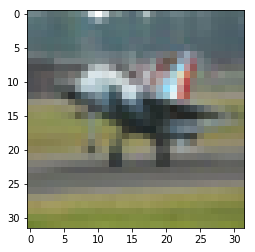

In [114]:
x,c = next(train_gen)
plt.imshow((x[0]+1)/2)
print(x[0].shape)
print(np.argmax(c))
pred = discriminator.predict(np.expand_dims(x[0],axis=0))
np.argmax(pred)

In [115]:
conv_output = Model(discriminator.inputs, discriminator.layers[1].output)

In [116]:
conv_output.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DiscriminatorInput (InputLay (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       6272      
Total params: 6,272
Trainable params: 6,272
Non-trainable params: 0
_________________________________________________________________


In [117]:
out = conv_output.predict(np.expand_dims(x[0],axis=0))

In [118]:
out = np.rollaxis(np.squeeze(out,axis=0),axis=2,start=0)[:100]
out.shape

(100, 16, 16)

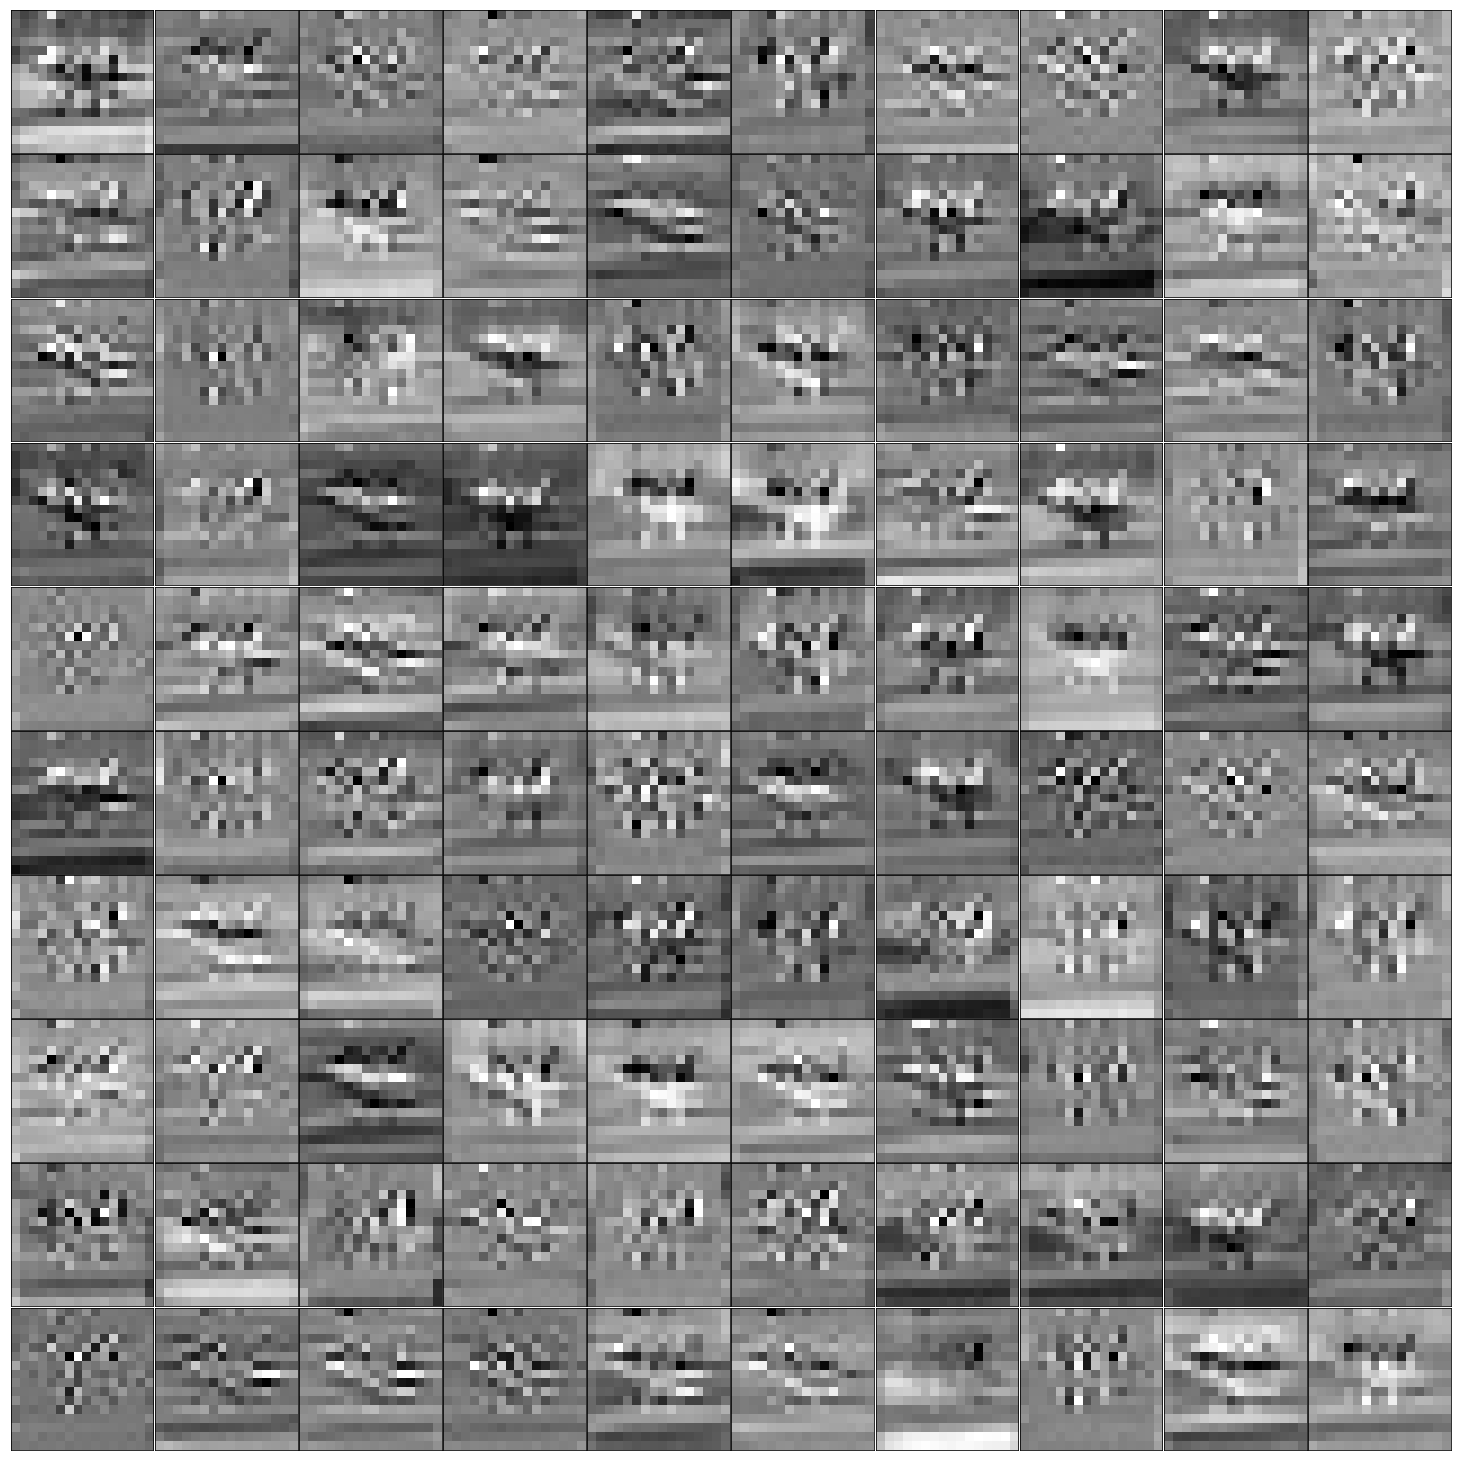

In [119]:
def plot_data(x,ax):
#     x = x.reshape((size,size))
    
    ax.imshow(x, cmap='gray')
#     if y is not None:
#         ax.scatter(y[0::2] , y[1::2] , marker='x', s=10)
def plot_images(x,batch_size=100):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)

    for i in range(batch_size):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    #     print(y['classes'][i])
    #     print(np.argmax(c[i]))
        plot_data(x[i], ax)
plot_images(out)

In [120]:
conv_output = Model(discriminator.inputs, discriminator.layers[4].output)

In [121]:
conv_output.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DiscriminatorInput (InputLay (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       6272      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
attention_1 (Attention)      [(None, 16, 16, 128), (25 20641     
Total params: 27,425
Trainable params: 27,169
Non-trainable params: 256
_________________________________________________________________


In [122]:
out, beta, gamma = conv_output.predict(np.expand_dims(x[0],axis=0))

In [123]:
out.shape, beta.shape, gamma

((1, 16, 16, 128), (1, 256, 256), array([-0.16638881], dtype=float32))

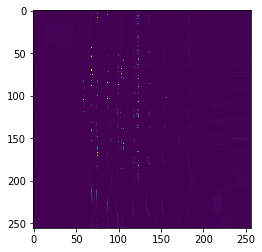

In [124]:
plt.imshow(beta[0])

In [125]:
out = np.rollaxis(np.squeeze(out,axis=0),axis=2,start=0)[:100]
out.shape

(100, 16, 16)

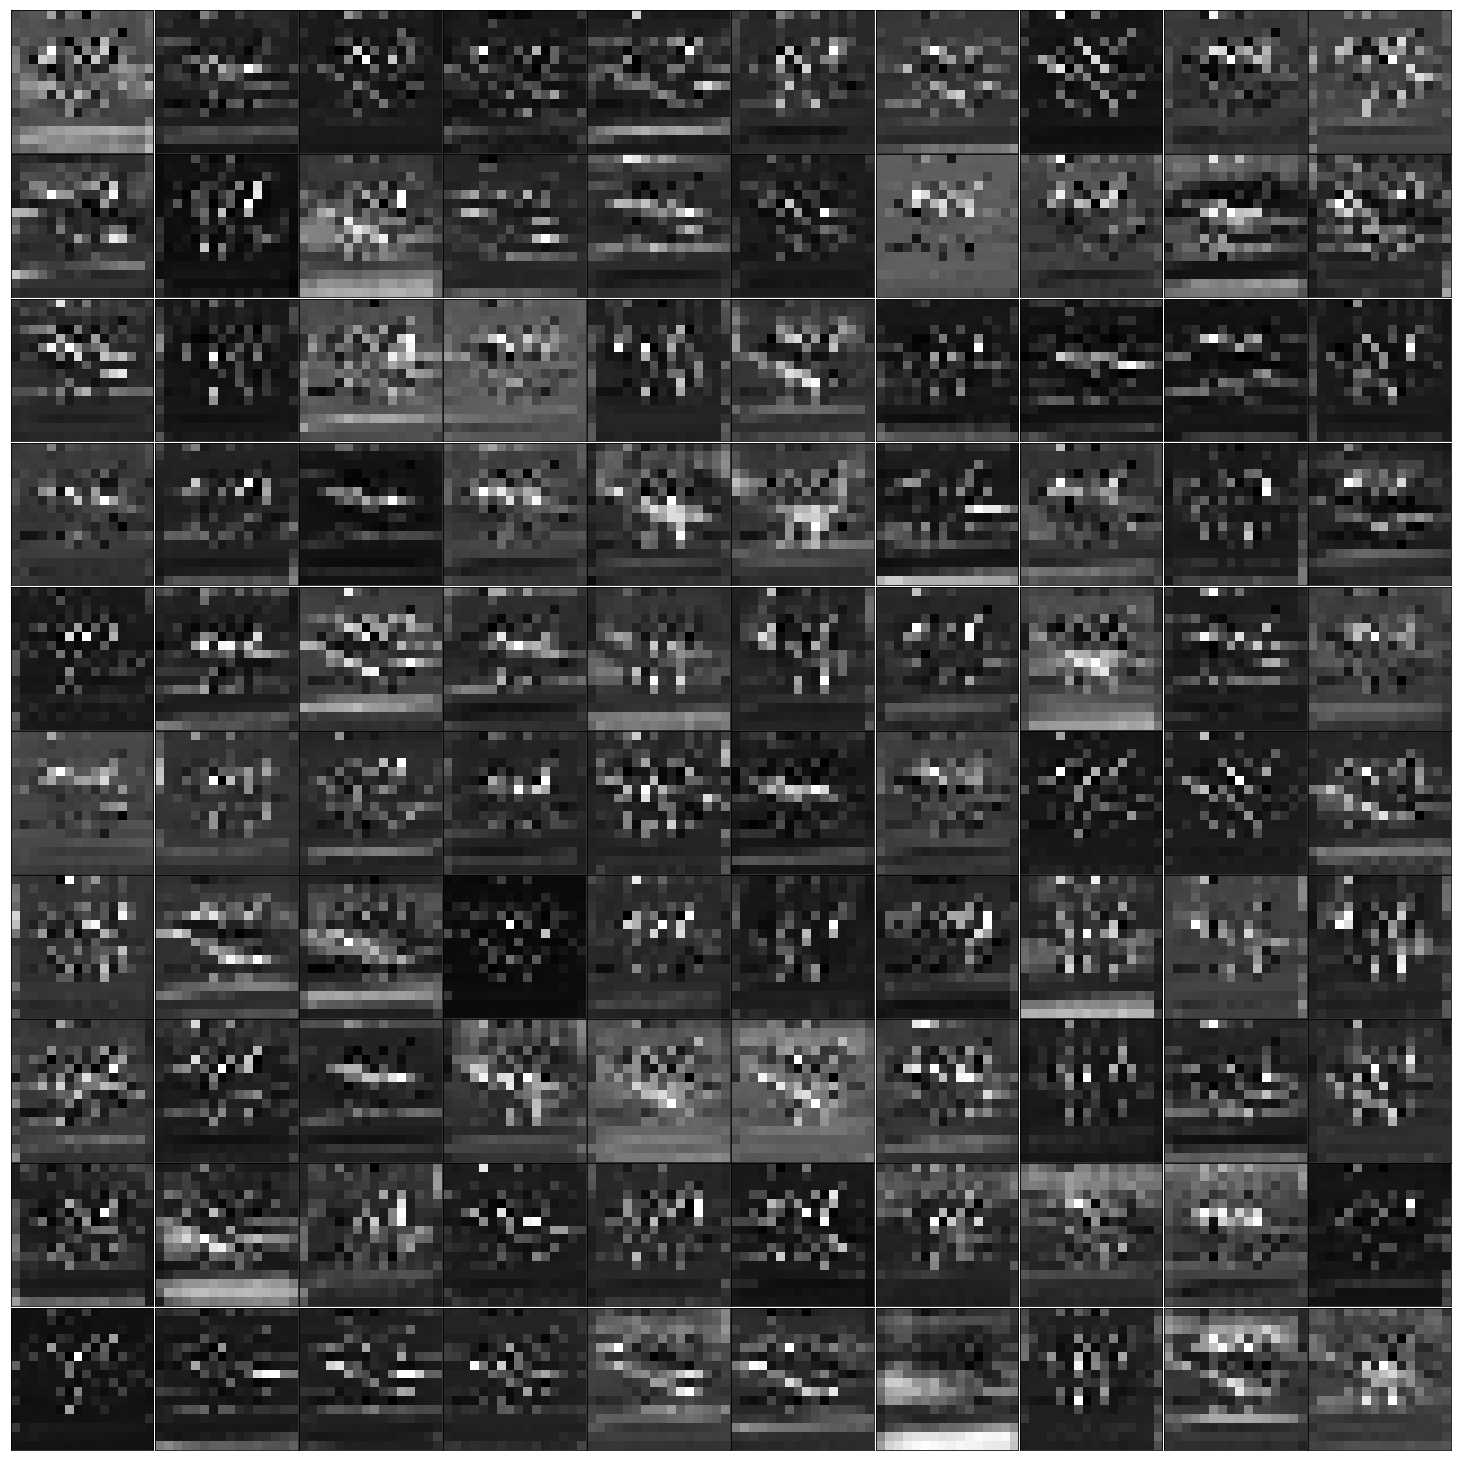

In [126]:
plot_images(out)

In [152]:
source = 70
related = np.argmax(beta[0][source])
related

100

In [160]:
x1,y1 = [(source//16),(source%16)]
x2,y2 = [(related//16),(related%16)]
img = (x[0]+1)/2
mask = np.zeros((16,16,3))

mask = cv2.circle(mask, center=(x1,y1), radius=1, color=(255,0,0), thickness = 1)
mask = cv2.circle(mask, center=(x2,y2), radius=1, color=(255,0,0), thickness = 1)
mask = cv2.resize((32,32),interpolation=cv2.INTER_CUBIC)
plt.imshow(mask)

TypeError: Required argument 'dsize' (pos 2) not found

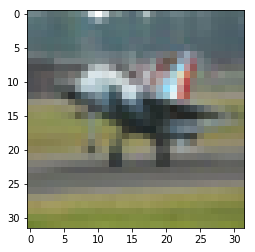

In [154]:
plt.imshow((x[0]+1)/2)

In [155]:
newimg = cv2.addWeighted((x[0]+1)/2,0.8,np.repeat(np.expand_dims(img,axis=-1),axis=-1,repeats=3),0.1,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


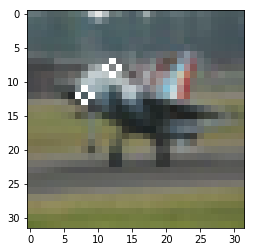

In [156]:
plt.imshow(newimg)